## Set Up : Mounting Google Drive and importing libraries

In [1]:
# Cell 1: Setup and Library Imports

import os
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Use TensorFlow 2.x and its built-in Keras API
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

import joblib

# Mount Google Drive (if using Google Colab)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


## Loading Dataset


In [2]:
# Cell 2: Load Dataset and Take Pristine Snapshot

# Define path to the dataset in Google Drive
data_path = '/content/drive/MyDrive/project_dataset.csv'
if not os.path.exists(data_path):
    raise FileNotFoundError(f"Dataset not found at {data_path}. Please check the file path.")

# Read CSV with Timestamp parsed as datetime
df = pd.read_csv(data_path, parse_dates=['Timestamp'])
df_original = df.copy(deep=True)  # Keep an untouched copy for reference

print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
print("Columns:", df.columns.tolist())
display(df.head())


Dataset loaded: 1000 rows, 14 columns
Columns: ['Timestamp', 'Latitude', 'Longitude', 'GHI (W/m²)', 'DNI (W/m²)', 'DHI (W/m²)', 'Temp (°C)', 'RH (%)', 'Pressure (hPa)', 'Dew Point (°C)', 'Wind Speed (m/s)', 'Cloud Type', 'Solar Zenith Angle (°)', 'Target_GHI_NextHour (W/m²)']


,Timestamp,Latitude,Longitude,GHI (W/m²),DNI (W/m²),DHI (W/m²),Temp (°C),RH (%),Pressure (hPa),Dew Point (°C),Wind Speed (m/s),Cloud Type,Solar Zenith Angle (°),Target_GHI_NextHour (W/m²)
0,1998-01-01 00:30:00,39.754943,-104.928739,341.581118,380.326236,72.649858,11.916165,35.728528,1010.482264,10.250311,3.278999,Clear,72.818352,383.384506
1,1998-01-01 01:00:00,39.832204,-105.039324,177.789175,300.146084,-34.446156,20.988743,98.138223,1009.356547,19.228097,3.180614,Cumulus,80.395158,654.211173
2,1998-01-01 01:30:00,39.880517,-104.736875,383.384506,349.160733,136.490584,25.183423,39.959014,1008.698430,21.821219,4.424296,Clear,30.029383,562.802620
3,1998-01-01 02:00:00,39.870209,-105.075542,654.211173,215.090519,502.119208,13.275915,67.850579,1011.101321,11.042622,2.273316,Overcast,69.173049,341.691203
4,1998-01-01 02:30:00,39.739962,-105.010037,562.802620,807.605770,-8.260897,16.168259,56.339117,1017.752069,13.354326,5.219018,Cumulus,73.775065,509.841850


## Data Preprocessing



In [3]:
# Cell 3: Complete and Corrected Data Preprocessing Cell

from sklearn.preprocessing import LabelEncoder

# 1. Parse 'Timestamp' and sort chronologically
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
df.sort_values('Timestamp', inplace=True)
df.reset_index(drop=True, inplace=True)
print("Parsed 'Timestamp' and sorted chronologically.")

# 2. Standardize column names FIRST to avoid lookup errors later
df.columns = (
    df.columns.str.replace(' ', '_')
              .str.replace('(', '')
              .str.replace(')', '')
              .str.replace('/', '_')
              .str.strip()
)
print("Standardized column names:", df.columns.tolist())

# 3. Drop rows with missing values in critical columns
critical_cols = [
    'GHI_W_m²', 'DNI_W_m²', 'DHI_W_m²',
    'Temp_°C', 'RH_%', 'Pressure_hPa',
    'Dew_Point_°C', 'Wind_Speed_m_s',
    'Solar_Zenith_Angle_°', 'Target_GHI_NextHour_W_m²'
]
missing_counts = df[critical_cols].isna().sum()
if missing_counts.any():
    print("Missing critical values found:\n", missing_counts[missing_counts > 0])
    df.dropna(subset=critical_cols, inplace=True)

# 4. Impute remaining numeric NaNs with median
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
for col in numeric_cols:
    if df[col].isna().any():
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)
        print(f"Imputed missing '{col}' with median={median_val}.")

# 5. Clip negative irradiance values to zero
irr_cols = ['GHI_W_m²', 'DNI_W_m²', 'DHI_W_m²']
for col in irr_cols:
    neg_count = (df[col] < 0).sum()
    if neg_count > 0:
        df[col] = df[col].clip(lower=0)
        print(f"Clipped {neg_count} negative values in '{col}' to 0.")

# 6. Drop duplicate rows
before = len(df)
df.drop_duplicates(inplace=True)
print(f"Dropped {before - len(df)} duplicate rows.")

# 7. Encode categorical 'Cloud_Type'
if 'Cloud_Type' in df.columns:
    df['Cloud_Type'] = df['Cloud_Type'].fillna('Unknown')
    encoder = LabelEncoder()
    df['Cloud_Type_Encoded'] = encoder.fit_transform(df['Cloud_Type'])
    print("Encoded 'Cloud_Type' numerically.")

# 8. Create classification target: GHI_Category
bins = [-np.inf, 300, 600, np.inf]
labels = ['Low', 'Medium', 'High']
df['GHI_Category'] = pd.cut(df['Target_GHI_NextHour_W_m²'], bins=bins, labels=labels)
print("Classification target 'GHI_Category' created.")
print(df['GHI_Category'].value_counts())

# 9. Handle outliers (5th to 95th percentile clipping)
outlier_cols = ['GHI_W_m²', 'DNI_W_m²', 'DHI_W_m²',
                'Temp_°C', 'RH_%', 'Pressure_hPa', 'Wind_Speed_m_s']
for col in outlier_cols:
    Q1 = df[col].quantile(0.05)
    Q3 = df[col].quantile(0.95)
    df[col] = df[col].clip(lower=Q1, upper=Q3)
print("Outliers handled with 5th–95th percentile clipping.")

# 10. Confirm no temporal leakage
assert df['Timestamp'].is_monotonic_increasing, "Timestamps not strictly increasing! Potential leakage!"
print("Confirmed timestamp monotonicity, no leakage risk.")

# 11. Save clean snapshot
df_clean = df.copy()
print("Saved cleaned snapshot as 'df_clean'.")


Parsed 'Timestamp' and sorted chronologically.
Standardized column names: ['Timestamp', 'Latitude', 'Longitude', 'GHI_W_m²', 'DNI_W_m²', 'DHI_W_m²', 'Temp_°C', 'RH_%', 'Pressure_hPa', 'Dew_Point_°C', 'Wind_Speed_m_s', 'Cloud_Type', 'Solar_Zenith_Angle_°', 'Target_GHI_NextHour_W_m²']
Clipped 424 negative values in 'DHI_W_m²' to 0.
Dropped 0 duplicate rows.
Encoded 'Cloud_Type' numerically.
Classification target 'GHI_Category' created.
GHI_Category
Medium    515
Low       320
High      165
Name: count, dtype: int64
Outliers handled with 5th–95th percentile clipping.
Confirmed timestamp monotonicity, no leakage risk.
Saved cleaned snapshot as 'df_clean'.


## EDA

EDA Columns: ['Timestamp', 'Latitude', 'Longitude', 'GHI_W_m²', 'DNI_W_m²', 'DHI_W_m²', 'Temp_°C', 'RH_%', 'Pressure_hPa', 'Dew_Point_°C', 'Wind_Speed_m_s', 'Cloud_Type', 'Solar_Zenith_Angle_°', 'Target_GHI_NextHour_W_m²', 'Cloud_Type_Encoded', 'GHI_Category']

GHI_Category counts:
 GHI_Category
Medium    515
Low       320
High      165
Name: count, dtype: int64


/tmp/ipython-input-4-2288229301.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='GHI_Category', data=df_eda, order=['Low', 'Medium', 'High'], palette='viridis')


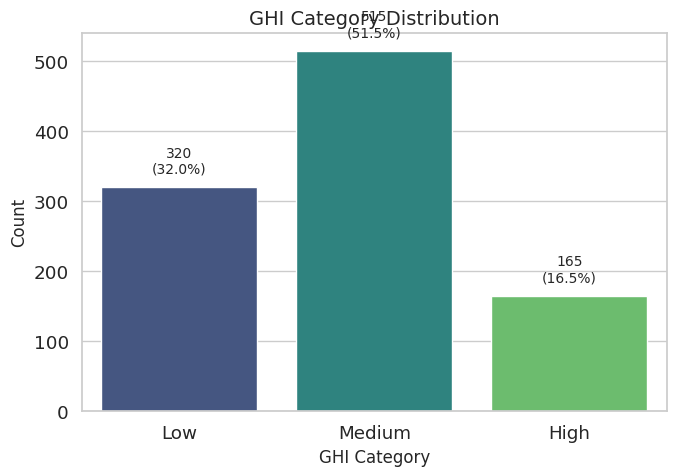

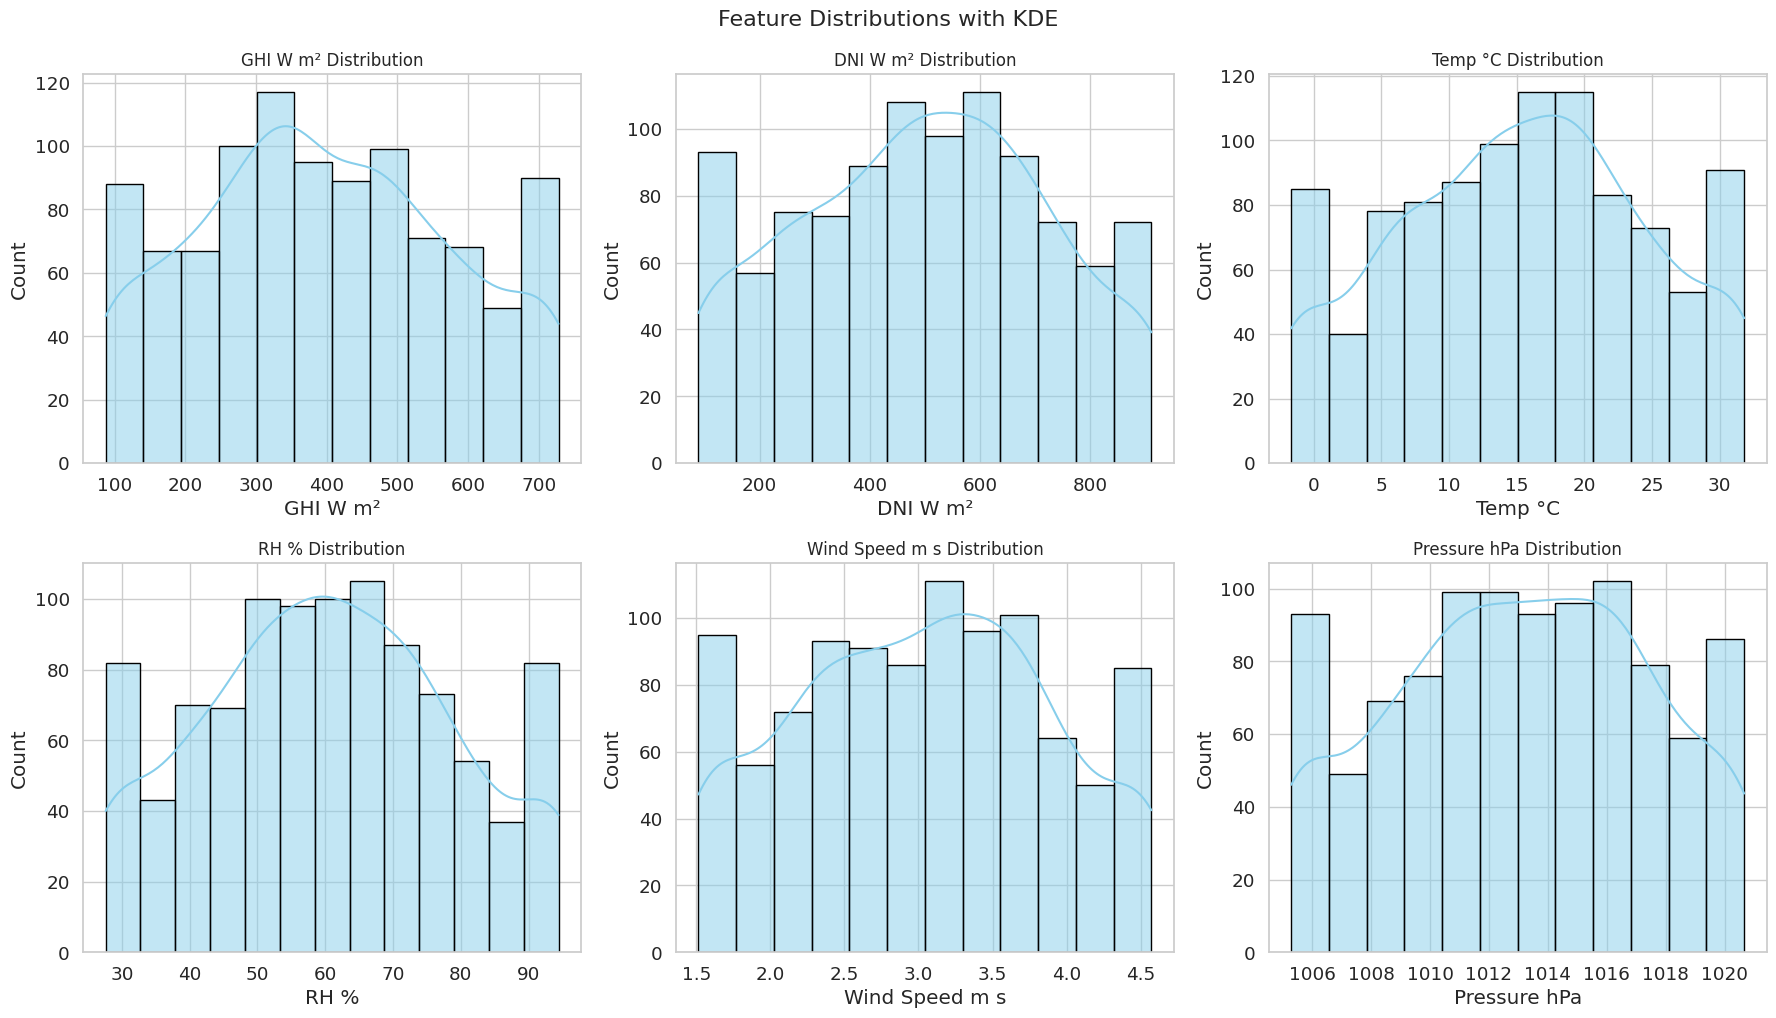

/tmp/ipython-input-4-2288229301.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_eda, x='GHI_Category', y=feat,
/tmp/ipython-input-4-2288229301.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_eda, x='GHI_Category', y=feat,
/tmp/ipython-input-4-2288229301.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_eda, x='GHI_Category', y=feat,
/tmp/ipython-input-4-2288229301.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue

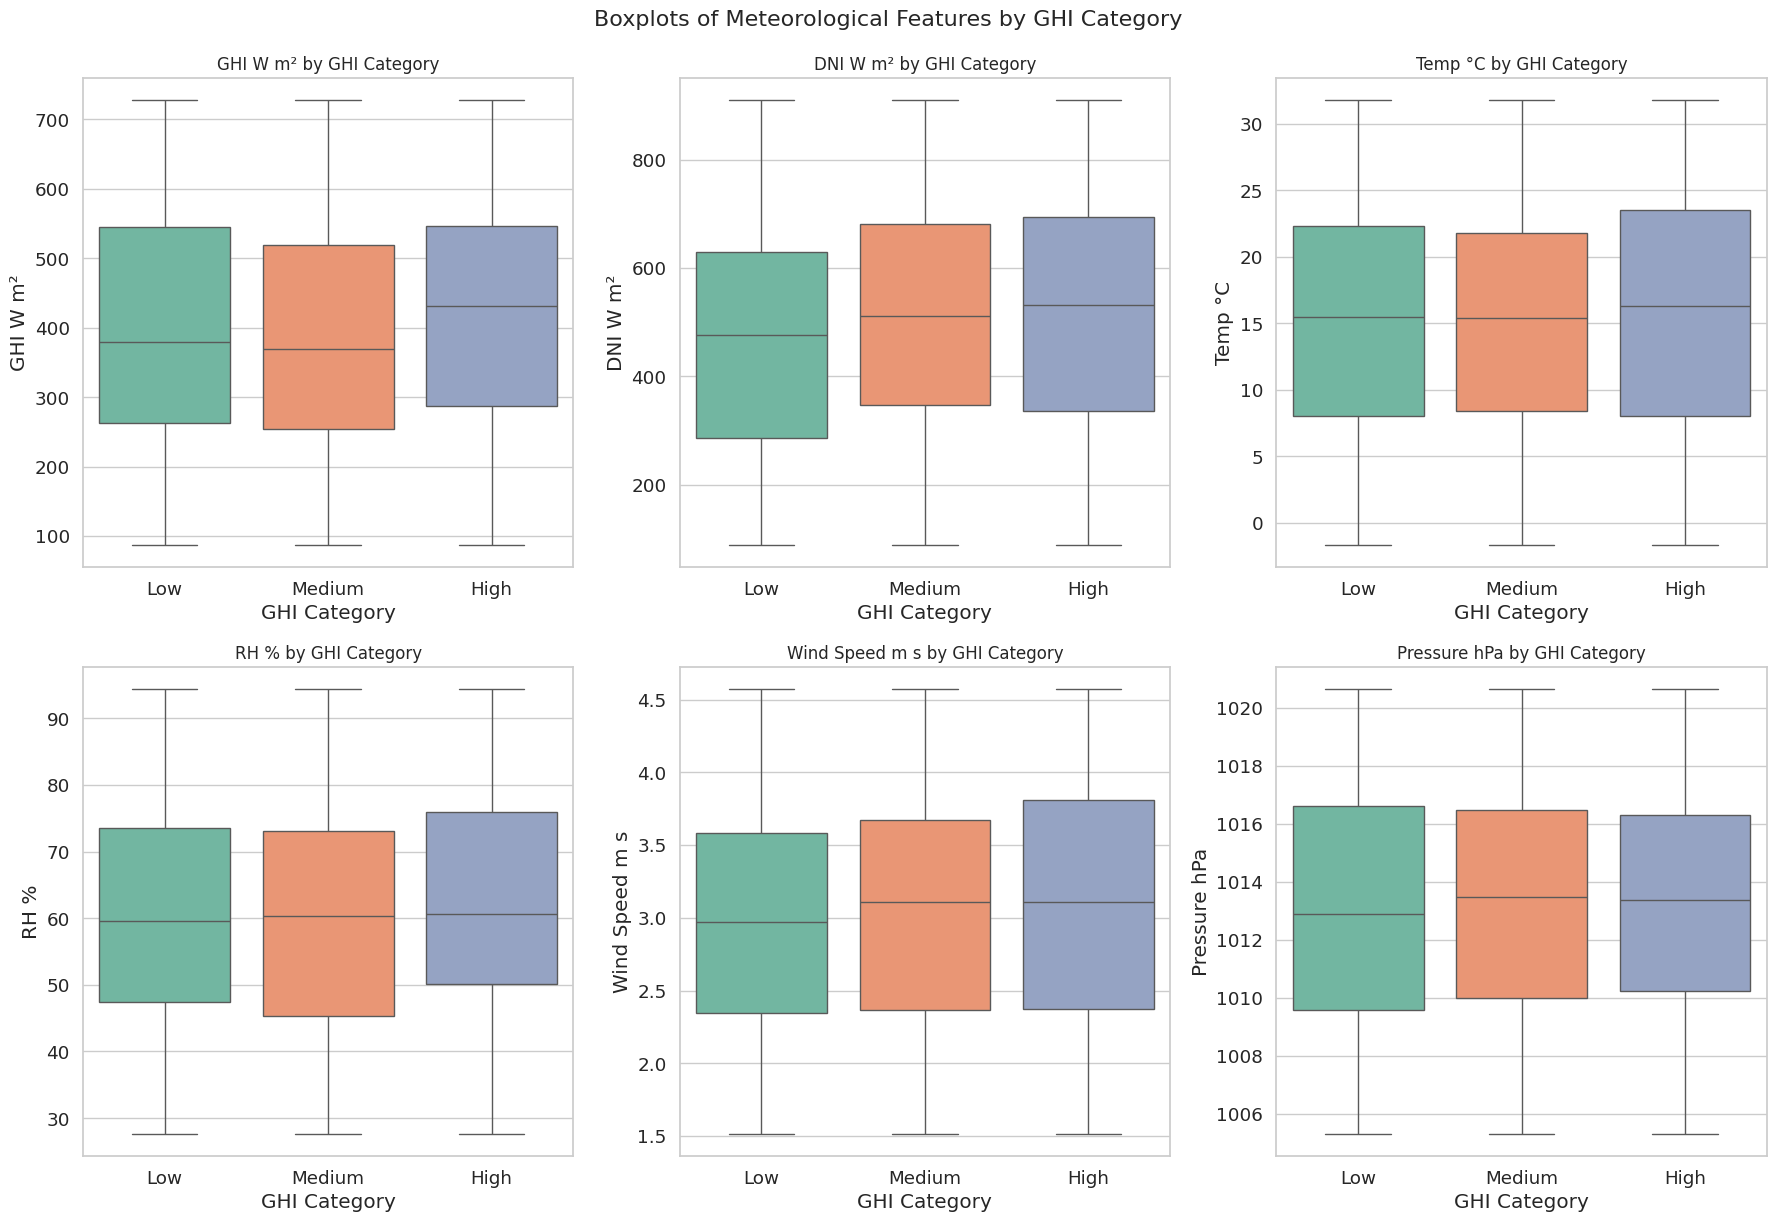

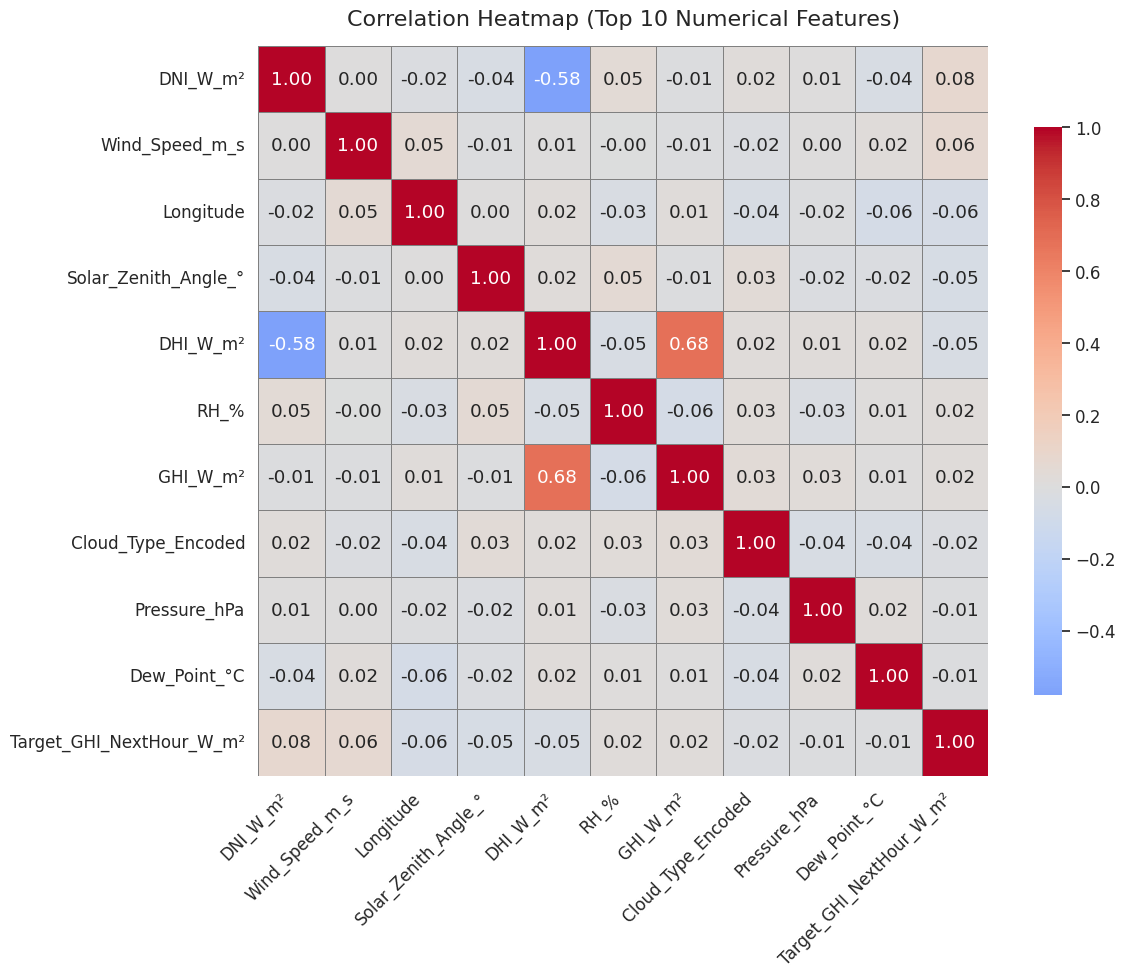

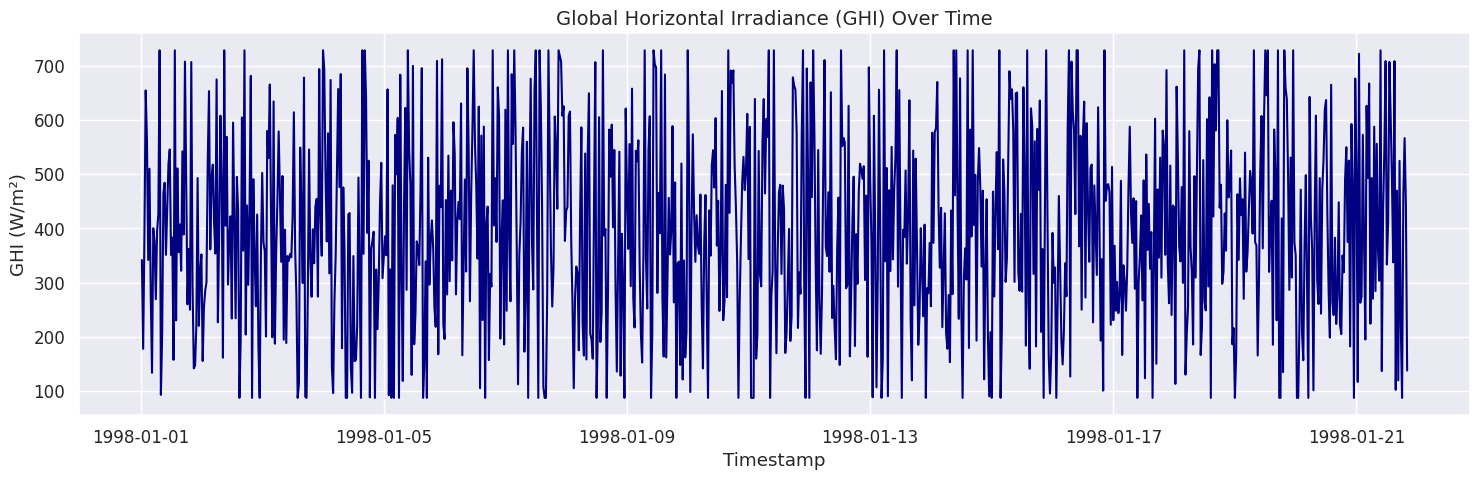

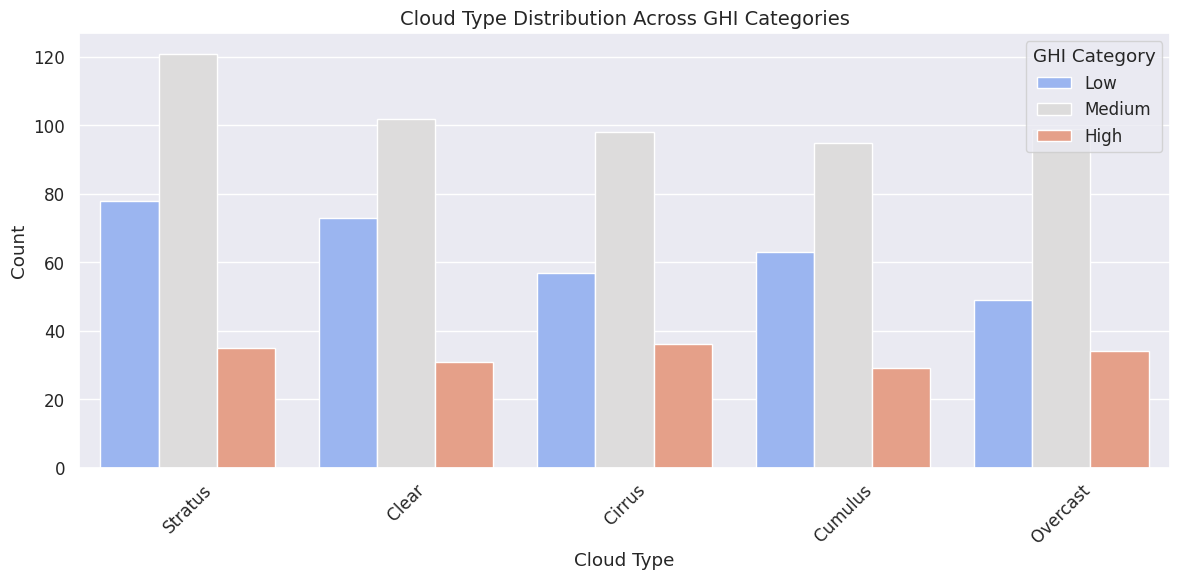

In [4]:
# Cell 4: Final EDA with Cleaned Correlation Heatmap

import seaborn as sns
import matplotlib.pyplot as plt

df_eda = df_clean.copy()
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.2)

print("EDA Columns:", df_eda.columns.tolist())
print("\nGHI_Category counts:\n", df_eda['GHI_Category'].value_counts())

# 1. GHI Category Distribution with Labels
plt.figure(figsize=(7, 5))
ax = sns.countplot(x='GHI_Category', data=df_eda, order=['Low', 'Medium', 'High'], palette='viridis')
plt.title('GHI Category Distribution', fontsize=14)
plt.xlabel('GHI Category', fontsize=12)
plt.ylabel('Count', fontsize=12)

for p in ax.patches:
    count = int(p.get_height())
    pct = f"{count / len(df_eda):.1%}"
    ax.annotate(f'{count}\n({pct})',
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10,
                xytext=(0, 8), textcoords='offset points')
plt.tight_layout()
plt.show()

# 2. Histograms + KDE of Selected Features
features = ['GHI_W_m²', 'DNI_W_m²', 'Temp_°C', 'RH_%', 'Wind_Speed_m_s', 'Pressure_hPa']
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, feat in enumerate(features):
    sns.histplot(data=df_eda, x=feat, kde=True, ax=axes[i],
                 color='skyblue', edgecolor='black')
    axes[i].set_title(f'{feat.replace("_", " ")} Distribution', fontsize=12)
    axes[i].set_xlabel(feat.replace("_", " "))
    axes[i].set_ylabel("Count")

plt.tight_layout()
plt.suptitle("Feature Distributions with KDE", fontsize=16, y=1.02)
plt.show()

# 3. Boxplots of Features by GHI Category
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, feat in enumerate(features):
    sns.boxplot(data=df_eda, x='GHI_Category', y=feat,
                order=['Low', 'Medium', 'High'],
                palette='Set2', ax=axes[i])
    axes[i].set_title(f'{feat.replace("_", " ")} by GHI Category', fontsize=12)
    axes[i].set_xlabel('GHI Category')
    axes[i].set_ylabel(feat.replace("_", " "))

plt.tight_layout()
plt.suptitle("Boxplots of Meteorological Features by GHI Category", fontsize=16, y=1.02)
plt.show()

# 4. Top-10 Correlation Heatmap with Target
target_col = 'Target_GHI_NextHour_W_m²'
numeric_cols = df_eda.select_dtypes(include='number').columns.drop(target_col, errors='ignore')

# Compute correlations with target
correlations = df_eda[numeric_cols].corrwith(df_eda[target_col]).abs().sort_values(ascending=False)

# Select top 10 features
top_features = correlations.head(10).index.tolist()
corr_subset = df_eda[top_features + [target_col]].corr()

plt.figure(figsize=(12, 10))
sns.set(font_scale=1.1)
sns.heatmap(
    corr_subset,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    linecolor='grey',
    square=True,
    cbar_kws={"shrink": 0.75}
)
plt.title("Correlation Heatmap (Top 10 Numerical Features)", fontsize=16, pad=15)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 5. Time-Series Line Plot of GHI
plt.figure(figsize=(15, 5))
sns.lineplot(data=df_eda, x='Timestamp', y='GHI_W_m²', color='navy')
plt.title('Global Horizontal Irradiance (GHI) Over Time', fontsize=14)
plt.xlabel('Timestamp')
plt.ylabel('GHI (W/m²)')
plt.tight_layout()
plt.show()

# 6. Cloud Type vs GHI Category
plt.figure(figsize=(12, 6))
sns.countplot(x='Cloud_Type', hue='GHI_Category', data=df_eda,
              order=df_eda['Cloud_Type'].value_counts().index,
              palette='coolwarm')
plt.title('Cloud Type Distribution Across GHI Categories', fontsize=14)
plt.xlabel('Cloud Type')
plt.ylabel('Count')
plt.legend(title='GHI Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Feature Engineering

In [5]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np

# Copy clean data
df_fe = df_clean.copy()

# 1. Confirm classification target exists
if 'GHI_Category' not in df_fe.columns:
    bins = [-np.inf, 300, 600, np.inf]
    labels = ['Low', 'Medium', 'High']
    df_fe['GHI_Category'] = pd.cut(df_fe['Target_GHI_NextHour_W_m²'], bins=bins, labels=labels)
    print("Created GHI_Category target for classification.")

# 2. Time-based features
df_fe['Hour'] = df_fe['Timestamp'].dt.hour
df_fe['Hour_sin'] = np.sin(2 * np.pi * df_fe['Hour'] / 24)
df_fe['Hour_cos'] = np.cos(2 * np.pi * df_fe['Hour'] / 24)
df_fe['DayOfYear'] = df_fe['Timestamp'].dt.dayofyear
df_fe['WeekOfYear'] = df_fe['Timestamp'].dt.isocalendar().week.astype(int)
df_fe['Month'] = df_fe['Timestamp'].dt.month
df_fe['Month_sin'] = np.sin(2 * np.pi * df_fe['Month'] / 12)
df_fe['Month_cos'] = np.cos(2 * np.pi * df_fe['Month'] / 12)

# 3. Derived feature: Temp × RH interaction
if {'Temp_°C', 'RH_%'}.issubset(df_fe.columns):
    df_fe['Temp_x_RH'] = df_fe['Temp_°C'] * df_fe['RH_%']

# 4. Add cosine of solar zenith angle
if 'Solar_Zenith_Angle_°' in df_fe.columns:
    df_fe['cos_zenith'] = np.cos(np.radians(df_fe['Solar_Zenith_Angle_°']))

# 5. Create lagged features for GHI
for lag in range(1, 4):
    df_fe[f'GHI_lag{lag}'] = df_fe['GHI_W_m²'].shift(lag)

# 6. Create past GHI difference
df_fe['GHI_diff_past'] = df_fe['GHI_W_m²'] - df_fe['GHI_lag1']

# 7. Drop rows with NaN values from lagging
df_fe.dropna(inplace=True)

# 8. Drop unused columns
drop_cols = ['Timestamp', 'Target_GHI_NextHour_W_m²']
if 'GHI_Class' in df_fe.columns:
    drop_cols.append('GHI_Class')
df_fe.drop(columns=drop_cols, inplace=True)

# 9. Define feature matrix X and classification target y
X = df_fe.drop(columns=['GHI_Category'])
y = df_fe['GHI_Category']

# 10. Scale numeric features
numeric_cols = X.select_dtypes(include=[np.number]).columns
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# 11. Encode target labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("✅ Feature Engineering Complete")
print(f"Feature Matrix X shape: {X.shape}")
print(f"Encoded Target Vector y shape: {y_encoded.shape}")
print("GHI Category Classes:", label_encoder.classes_)

# Optionally keep for model access
X_final = X.copy()
y_final = y_encoded.copy()

✅ Feature Engineering Complete
Feature Matrix X shape: (997, 27)
Encoded Target Vector y shape: (997,)
GHI Category Classes: ['High' 'Low' 'Medium']


## Time-aware Chronological Split Data Spltting



In [6]:
from sklearn.preprocessing import LabelEncoder

# Ensure X_final and y_final exist
X_sorted = X_final.copy()
y_sorted = y_final.copy()

# Confirm chronological order (if not already sorted by timestamp earlier)
# You already sorted during preprocessing — just make sure indexes align
X_sorted.reset_index(drop=True, inplace=True)
y_sorted = pd.Series(y_sorted).reset_index(drop=True)

# Train/test split: 80% training, 20% testing
n_samples = len(X_sorted)
train_size = int(0.8 * n_samples)
test_size = n_samples - train_size

X_train = X_sorted.iloc[:train_size]
X_test  = X_sorted.iloc[train_size:]
y_train = y_sorted.iloc[:train_size]
y_test  = y_sorted.iloc[train_size:]

# Decode integer labels back to class names
y_train_decoded = label_encoder.inverse_transform(y_train)
y_test_decoded  = label_encoder.inverse_transform(y_test)
class_names = label_encoder.classes_

print(f"✅ Chronological Split Done\nTotal samples: {n_samples}")
print(f"Training samples: {train_size}")
print(f"Testing samples: {test_size}\n")

# Class balance in training
print("📊 Class distribution in TRAIN set:")
train_counts = pd.Series(y_train_decoded).value_counts().to_dict()
for cls in class_names:
    count = train_counts.get(cls, 0)
    pct = 100 * count / train_size
    print(f"  {cls}: {count} ({pct:.1f}%)")
    if count == 0:
        print(f"⚠️ WARNING: Class '{cls}' is missing in TRAINING data!")

# Class balance in testing
print("\n📊 Class distribution in TEST set:")
test_counts = pd.Series(y_test_decoded).value_counts().to_dict()
for cls in class_names:
    count = test_counts.get(cls, 0)
    pct = 100 * count / test_size
    print(f"  {cls}: {count} ({pct:.1f}%)")
    if count == 0:
        print(f"⚠️ WARNING: Class '{cls}' is missing in TEST data!")

✅ Chronological Split Done
Total samples: 997
Training samples: 797
Testing samples: 200

📊 Class distribution in TRAIN set:
  High: 128 (16.1%)
  Low: 258 (32.4%)
  Medium: 411 (51.6%)

📊 Class distribution in TEST set:
  High: 36 (18.0%)
  Low: 62 (31.0%)
  Medium: 102 (51.0%)


## Random Forest Classifier (Full Build – From Scratch)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 15.8 MB/s eta 0:00:00

🚀 Starting Random Forest Training with Hyperparameter Tuning and Explainability Tools...


/tmp/ipython-input-7-3356739529.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = encoder.fit_transform(X_train[col].astype(str))
/tmp/ipython-input-7-3356739529.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = encoder.transform(X_test[col].astype(str))
[I 2025-07-30 14:00:56,087] A new study created in memory with name: no-name-a07de166-3501-4828-8807-32a891c7feff


🔠 Encoding categorical columns: ['Cloud_Type']
🔍 Running Optuna for hyperparameter search...


[I 2025-07-30 14:00:58,159] Trial 0 finished with value: 0.3912027477421365 and parameters: {'n_estimators': 250, 'max_depth': 29, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.3912027477421365.
[I 2025-07-30 14:01:01,844] Trial 1 finished with value: 0.40147770062736093 and parameters: {'n_estimators': 447, 'max_depth': 20, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.40147770062736093.
[I 2025-07-30 14:01:05,091] Trial 2 finished with value: 0.3899566718626146 and parameters: {'n_estimators': 172, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 1 with value: 0.40147770062736093.
[I 2025-07-30 14:01:06,982] Trial 3 finished with value: 0.3844249804255884 and parameters: {'n_estimators': 155, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.401477700627


🏆 Best trial F1 Score: 0.4015
Selected Parameters: {'n_estimators': 447, 'max_depth': 20, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'sqrt'}

📊 Evaluation Report:
              precision    recall  f1-score   support

        High       0.00      0.00      0.00        36
         Low       0.38      0.16      0.23        62
      Medium       0.51      0.84      0.63       102

    accuracy                           0.48       200
   macro avg       0.30      0.33      0.29       200
weighted avg       0.38      0.48      0.39       200



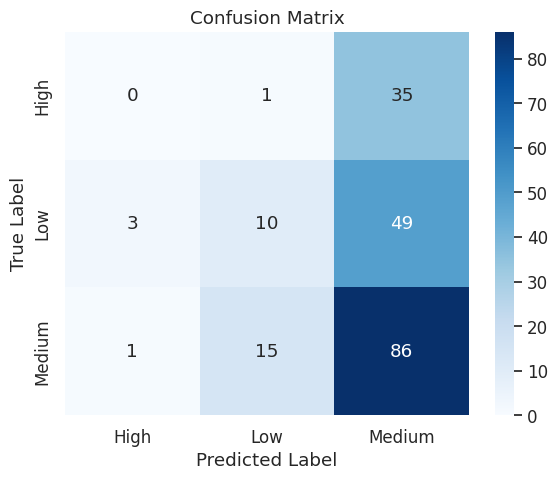

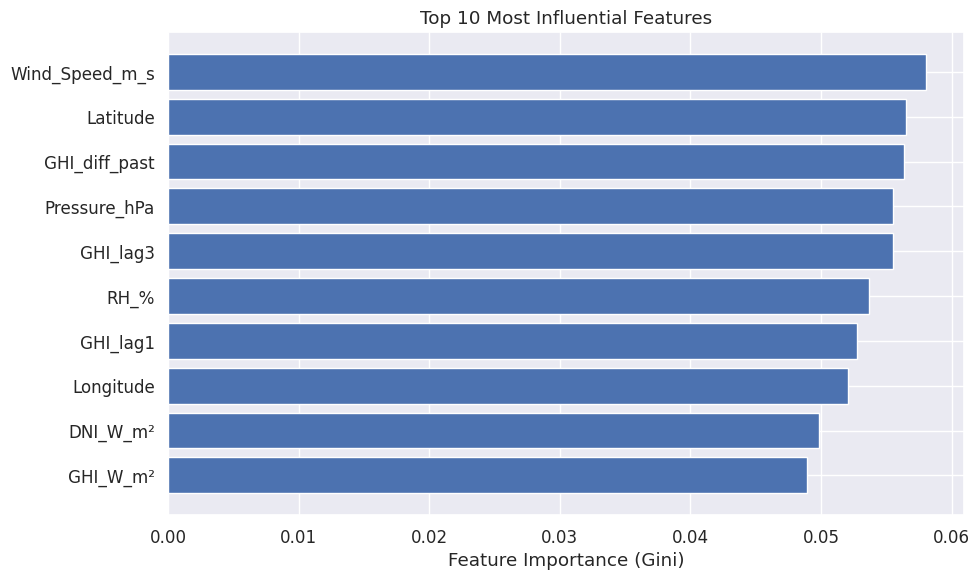


📈 Generating SHAP summary plot...


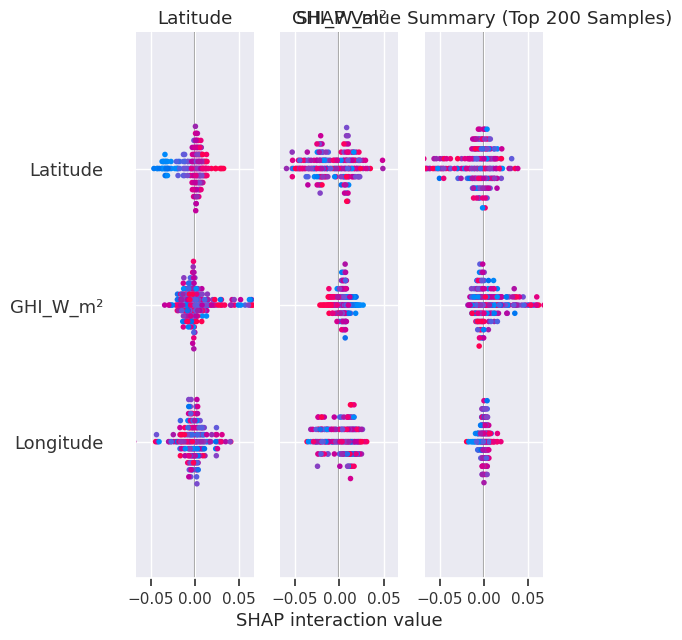

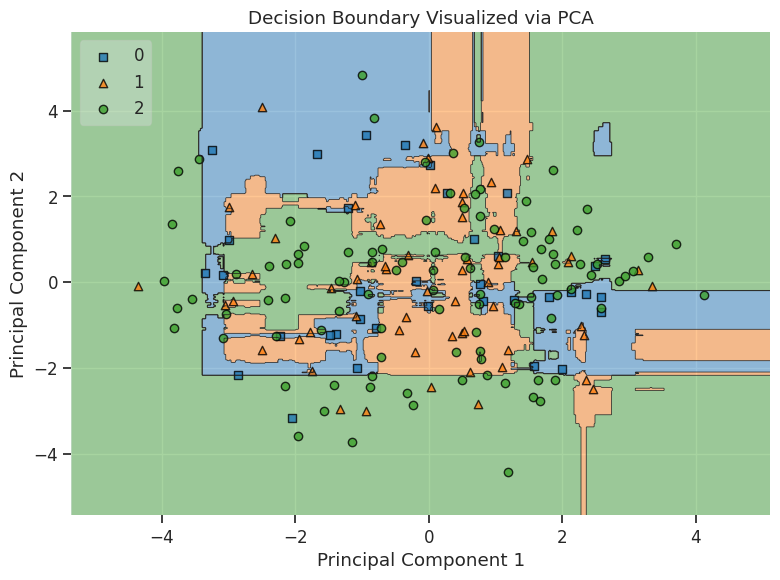

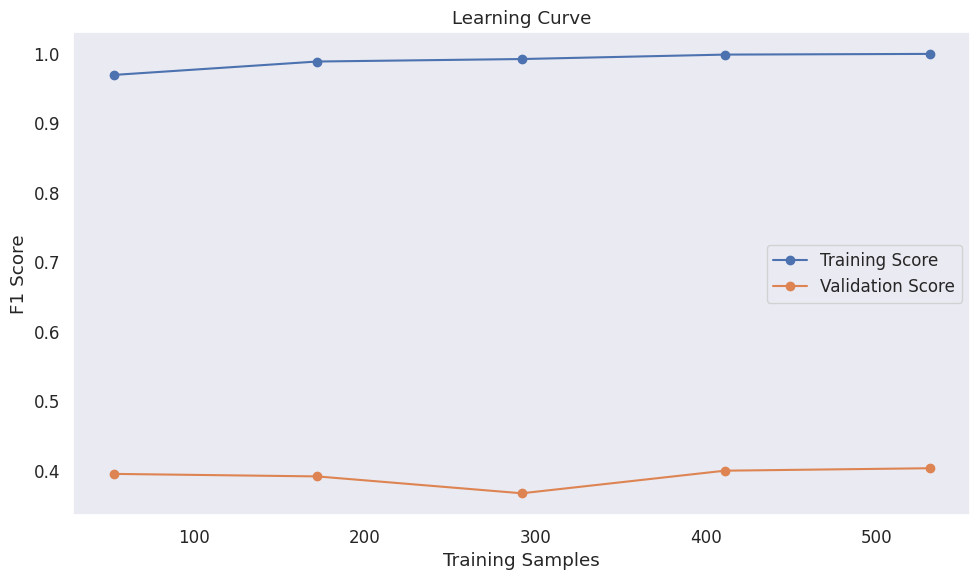


💾 Model successfully saved to 'rf_model_ghi_class.pkl'

✅ Summary of Enhancements:
- Hyperparameter tuning with Optuna ✓
- Balanced class handling ✓
- Feature importance and SHAP explainability ✓
- PCA visualization for decision boundaries ✓
- Learning curve to assess generalization ✓
- Model persistence for reuse ✓


In [7]:
# First, install required packages
!pip install optuna shap mlxtend --quiet

# Begin model training pipeline
print("\n🚀 Starting Random Forest Training with Hyperparameter Tuning and Explainability Tools...")

import optuna
from optuna.samplers import TPESampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_decision_regions
from sklearn.model_selection import learning_curve, TimeSeriesSplit

# ------------------ Encode Categorical Features ------------------
# Ensure all features are numeric before modeling
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()
if cat_cols:
    print(f"🔠 Encoding categorical columns: {cat_cols}")
    for col in cat_cols:
        encoder = LabelEncoder()
        X_train[col] = encoder.fit_transform(X_train[col].astype(str))
        X_test[col] = encoder.transform(X_test[col].astype(str))
else:
    print("✅ No categorical features detected in training data.")

# ------------------ Bayesian Hyperparameter Tuning ------------------
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'class_weight': 'balanced',
        'random_state': 42,
        'n_jobs': -1
    }

    tscv = TimeSeriesSplit(n_splits=3)
    scores = []
    for train_idx, val_idx in tscv.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        clf = RandomForestClassifier(**params)
        clf.fit(X_tr, y_tr)
        preds = clf.predict(X_val)
        scores.append(f1_score(y_val, preds, average='weighted'))

    return np.mean(scores)

print("🔍 Running Optuna for hyperparameter search...")
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=5, timeout=600)

print(f"\n🏆 Best trial F1 Score: {study.best_value:.4f}")
print("Selected Parameters:", study.best_params)

# ------------------ Train Final Model ------------------
best_params = study.best_params
best_params.update({'class_weight': 'balanced', 'random_state': 42, 'n_jobs': -1})
rf_model = RandomForestClassifier(**best_params)
rf_model.fit(X_train, y_train)

# ------------------ Evaluation ------------------
y_pred = rf_model.predict(X_test)

# Ensure test labels and predictions are decoded
if 'label_encoder' not in globals():
    label_encoder = LabelEncoder()
    label_encoder.fit(y_train.tolist() + y_test.tolist())

class_names = label_encoder.classes_
y_pred_decoded = label_encoder.inverse_transform(y_pred)
y_test_decoded = label_encoder.inverse_transform(y_test)

print("\n📊 Evaluation Report:")
print(classification_report(y_test_decoded, y_pred_decoded, target_names=class_names))

# ------------------ Confusion Matrix ------------------
plt.figure(figsize=(6, 5))
try:
    cm = confusion_matrix(y_test_decoded, y_pred_decoded, labels=class_names)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()
except ValueError as e:
    print("⚠️ Skipping confusion matrix due to label mismatch:", e)

# ------------------ Feature Importance ------------------
plt.figure(figsize=(10, 6))
importances = rf_model.feature_importances_
sorted_idx = np.argsort(importances)[-10:]
plt.barh(range(len(sorted_idx)), importances[sorted_idx])
plt.yticks(range(len(sorted_idx)), X_train.columns[sorted_idx])
plt.title('Top 10 Most Influential Features')
plt.xlabel('Feature Importance (Gini)')
plt.tight_layout()
plt.show()

# ------------------ SHAP Summary ------------------
print("\n📈 Generating SHAP summary plot...")
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test.iloc[:200])
shap.summary_plot(shap_values, X_test.iloc[:200], class_names=class_names, show=False)
plt.title("SHAP Value Summary (Top 200 Samples)")
plt.tight_layout()
plt.show()

# ------------------ PCA-Based Decision Boundary ------------------
pca = PCA(n_components=2)
X_proj = pca.fit_transform(X_test.iloc[:500])
pca_clf = RandomForestClassifier(**best_params)
pca_clf.fit(X_proj, y_test.iloc[:500])
plt.figure(figsize=(8, 6))
plot_decision_regions(X_proj, y_test.iloc[:500].to_numpy(), clf=pca_clf, legend=2)
plt.title('Decision Boundary Visualized via PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.tight_layout()
plt.show()

# ------------------ Learning Curve ------------------
train_sizes, train_scores, val_scores = learning_curve(
    rf_model, X_train, y_train,
    cv=3, scoring='f1_weighted', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training Score')
plt.plot(train_sizes, np.mean(val_scores, axis=1), 'o-', label='Validation Score')
plt.xlabel('Training Samples')
plt.ylabel('F1 Score')
plt.title('Learning Curve')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# ------------------ Save Trained Model ------------------
model_path = 'rf_model_ghi_class.pkl'
joblib.dump(rf_model, model_path)
print(f"\n💾 Model successfully saved to '{model_path}'")

# ------------------ Summary ------------------
print("\n✅ Summary of Enhancements:")
print("- Hyperparameter tuning with Optuna ✓")
print("- Balanced class handling ✓")
print("- Feature importance and SHAP explainability ✓")
print("- PCA visualization for decision boundaries ✓")
print("- Learning curve to assess generalization ✓")
print("- Model persistence for reuse ✓")


## XGBoost Classifier – Chronological Split & Evaluation

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.5/322.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.4/35.4 MB 31.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

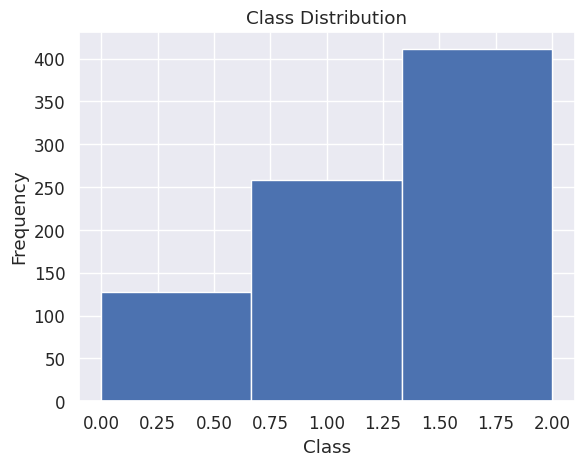

[I 2025-07-30 14:04:08,190] A new study created in memory with name: no-name-71b0da16-6ec6-4f2b-9682-2d11f786e6ad


Class weights for XGBoost:
  High   → 2.08
  Low    → 1.03
  Medium → 0.65

🔍 Running Optuna for hyperparameter search...


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:04:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-07-30 14:04:08,901] Trial 0 finished with value: 0.42091405633956 and parameters: {'n_estimators': 447, 'max_depth': 6, 'learning_rate': 0.24173924048691312, 'gamma': 0.4811209944481872, 'min_child_weight': 7, 'subsample': 0.8864669230002022, 'colsample_bytree': 0.9896093664012906, 'max_delta_step': 0.2218439303276647}. Best is trial 0 with value: 0.42091405633956.
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:04:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-07-30 14:04:09,661] Trial 1 finished with value: 0.39194868497954416 and parameters: {'n_estimators': 188, 'max_depth': 4, 'learning_rate': 0.017856347018253435, 'gam

✔ Optuna completed in 35.62s

▶ Training final XGBoost model...
✔ Final model trained in 3.67s

Best XGBoost Parameters: {'n_estimators': 343, 'max_depth': 4, 'learning_rate': 0.11052451202403867, 'gamma': 0.08708901699104826, 'min_child_weight': 4, 'subsample': 0.9557086079197882, 'colsample_bytree': 0.6230691568813126, 'max_delta_step': 0.9568818652574987, 'objective': 'multi:softprob', 'eval_metric': 'mlogloss', 'use_label_encoder': False, 'random_state': 42, 'n_jobs': -1}
Best CV Weighted F1: 0.4377

XGBoost Metrics:
Accuracy:      0.4200
Weighted F1:   0.3752
ROC-AUC:       0.5132

XGBoost Classification Report:
               precision    recall  f1-score   support

        High       0.00      0.00      0.00        36
         Low       0.32      0.27      0.30        62
      Medium       0.48      0.66      0.56       102

    accuracy                           0.42       200
   macro avg       0.27      0.31      0.28       200
weighted avg       0.35      0.42      0.38     

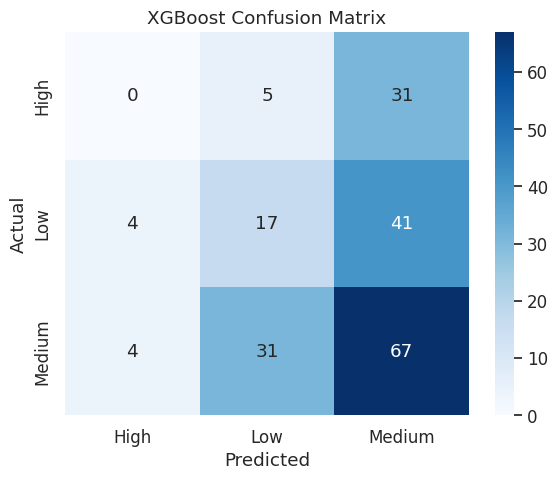

/tmp/ipython-input-8-2284026583.py:176: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gain_imp.values, y=gain_imp.index, palette='viridis')


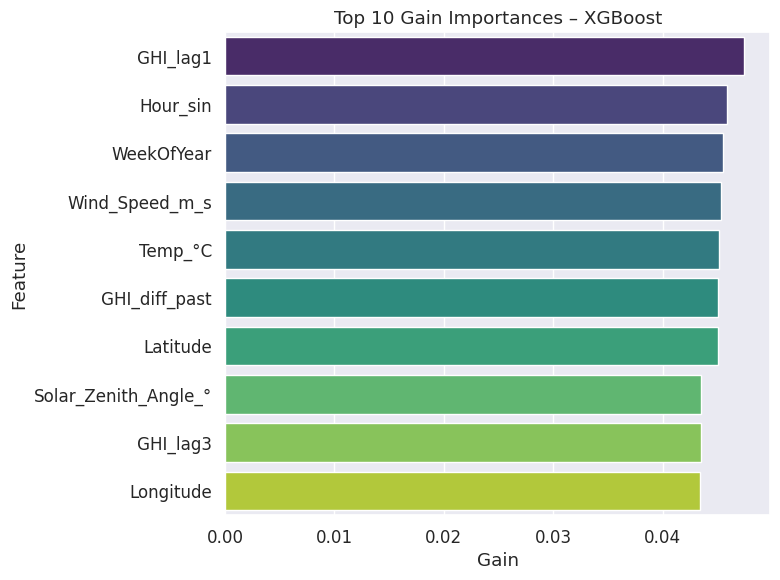


XGBoost Top 10 Permutation Importances:


,Feature,Mean Importance,Std Dev
7,Pressure_hPa,0.0015,0.015977
18,Month,0.0000,0.000000
17,WeekOfYear,0.0000,0.000000
19,Month_sin,0.0000,0.000000
16,DayOfYear,0.0000,0.000000
20,Month_cos,0.0000,0.000000
14,Hour_sin,-0.0095,0.007566
15,Hour_cos,-0.0095,0.011057
0,Latitude,-0.0115,0.005025
24,GHI_lag2,-0.0150,0.013038



📈 Generating SHAP summary plot...


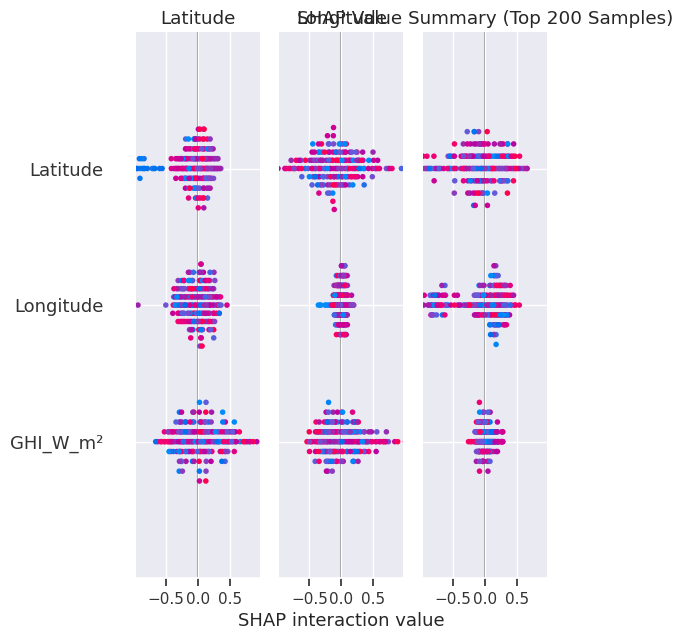


✅ Saved artifacts:
 - xgb_advanced_model.pkl
 - scaler.pkl
 - label_encoder.pkl
 - feature_list_xgb.json


In [8]:
# First, install required packages and force upgrade XGBoost
!pip install optuna xgboost shap --quiet
!pip install --upgrade xgboost --force-reinstall --quiet

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
from xgboost import XGBClassifier, __version__ as xgboost_version
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    confusion_matrix, roc_auc_score
)
from sklearn.inspection import permutation_importance
import optuna
import shap

print(f"XGBoost version: {xgboost_version}")

# ── 0. Guard: Ensure preceding cells were run ───────────────────────
required = ['X_train', 'X_test', 'y_train', 'y_test', 'label_encoder', 'scaler']
missing = [v for v in required if v not in globals()]
if missing:
    raise NameError(
        f"Variables not found: {missing}. "
        "Please run Feature Engineering (Cell 5) and Data Splitting (Cell 6) first."
    )

# ── 1. Drop any non-numeric columns ───────────────────────────────
non_num = X_train.select_dtypes(exclude=[np.number]).columns.tolist()
if non_num:
    print(f"⚠️ Dropping non-numeric columns: {non_num}")
X_tr = X_train.drop(columns=non_num)
X_te = X_test.drop(columns=non_num)

# ── 2. Compute class/sample weights and check distribution ────────
classes = np.unique(y_train)
cw = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight = dict(zip(classes, cw))
sample_w = np.array([class_weight[c] for c in y_train])
print("Class distribution:")
print(y_train.value_counts(normalize=True))
plt.hist(y_train, bins=len(classes))
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution')
plt.show()
print("Class weights for XGBoost:")
for cls, w in class_weight.items():
    print(f"  {label_encoder.inverse_transform([cls])[0]:<6} → {w:.2f}")
print()

# ── 3. Define Optuna objective for hyperparameter tuning ──────────
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'gamma': trial.suggest_float('gamma', 0.0, 0.5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'max_delta_step': trial.suggest_float('max_delta_step', 0, 1)
    }
    model = XGBClassifier(
        objective='multi:softprob',
        eval_metric='mlogloss',
        use_label_encoder=False,
        random_state=42,
        n_jobs=-1,
        **params
    )
    # Split for validation
    X_train_split, X_val, y_train_split, y_val = train_test_split(X_tr, y_train, test_size=0.2, random_state=42)
    sample_w_split = np.array([class_weight[c] for c in y_train_split])
    try:
        model.fit(
            X_train_split, y_train_split,
            sample_weight=sample_w_split,
            # Temporarily disable early_stopping_rounds due to version issue
            # eval_set=[(X_val, y_val)],
            # early_stopping_rounds=10,
            verbose=False
        )
        y_pred = model.predict(X_te)
        return f1_score(y_test, y_pred, average='weighted')
    except Exception as e:
        print(f"Error in trial with params {params}: {str(e)}")
        raise  # Re-raise to let Optuna handle the failure

# ── 4. Run Optuna optimization with debug handling ────────────────
print("🔍 Running Optuna for hyperparameter search...")
start = time.time()
study = optuna.create_study(direction='maximize')
try:
    study.optimize(objective, n_trials=20, timeout=600)
except Exception as e:
    print(f"Optimization failed: {str(e)}")
optuna_time = time.time() - start
print(f"✔ Optuna completed in {optuna_time:.2f}s\n")

# ── 5. Train final model with best parameters ────────────────────
if study.best_params:
    best_params = study.best_params
    best_params.update({
        'objective': 'multi:softprob',
        'eval_metric': 'mlogloss',
        'use_label_encoder': False,
        'random_state': 42,
        'n_jobs': -1
    })
    xgb_clf = XGBClassifier(**best_params)
    print("▶ Training final XGBoost model...")
    start = time.time()
    xgb_clf.fit(X_tr, y_train, sample_weight=sample_w)
    train_time = time.time() - start
    print(f"✔ Final model trained in {train_time:.2f}s\n")
else:
    print("⚠️ No successful trials found, using default parameters.")
    xgb_clf = XGBClassifier(
        objective='multi:softprob',
        eval_metric='mlogloss',
        use_label_encoder=False,
        random_state=42,
        n_jobs=-1
    )
    xgb_clf.fit(X_tr, y_train, sample_weight=sample_w)
    train_time = time.time() - start
    print(f"✔ Final model trained with defaults in {train_time:.2f}s\n")

# ── 6. Display best parameters and CV score ───────────────────────
if study.best_params:
    print("Best XGBoost Parameters:", best_params)
    print(f"Best CV Weighted F1: {study.best_value:.4f}\n")
else:
    print("⚠️ No best parameters available due to optimization failure.\n")

# ── 7. Inference and evaluation ──────────────────────────────────
y_pred_xgb = xgb_clf.predict(X_te)
y_proba_xgb = xgb_clf.predict_proba(X_te)

acc_xgb = accuracy_score(y_test, y_pred_xgb)
f1w_xgb = f1_score(y_test, y_pred_xgb, average='weighted')
y_bin = label_binarize(y_test, classes=classes)
roc_auc_xgb = roc_auc_score(y_bin, y_proba_xgb, multi_class='ovr', average='macro')

print("XGBoost Metrics:")
print(f"Accuracy:      {acc_xgb:.4f}")
print(f"Weighted F1:   {f1w_xgb:.4f}")
print(f"ROC-AUC:       {roc_auc_xgb:.4f}\n")
print("XGBoost Classification Report:\n",
      classification_report(y_test, y_pred_xgb, target_names=label_encoder.classes_))

# ── 8. Plot Confusion Matrix ─────────────────────────────────────
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('XGBoost Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# ── 9. Plot Gain Feature Importances ─────────────────────────────
gain_imp = pd.Series(xgb_clf.feature_importances_, index=X_tr.columns)
gain_imp = gain_imp.sort_values(ascending=False).head(10)
plt.figure(figsize=(8, 6))
sns.barplot(x=gain_imp.values, y=gain_imp.index, palette='viridis')
plt.title('Top 10 Gain Importances – XGBoost')
plt.xlabel('Gain')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# ── 10. Permutation Feature Importance ───────────────────────────
perm_xgb = permutation_importance(xgb_clf, X_te, y_test, n_repeats=10, random_state=42, n_jobs=-1)
perm_df_xgb = pd.DataFrame({
    'Feature': X_te.columns,
    'Mean Importance': perm_xgb.importances_mean,
    'Std Dev': perm_xgb.importances_std
}).sort_values('Mean Importance', ascending=False)
print("\nXGBoost Top 10 Permutation Importances:")
display(perm_df_xgb.head(10))

# ── 11. SHAP Summary Plot ────────────────────────────────────────
print("\n📈 Generating SHAP summary plot...")
explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(X_te.iloc[:200])
shap.summary_plot(shap_values, X_te.iloc[:200], class_names=label_encoder.classes_, show=False)
plt.title("SHAP Value Summary (Top 200 Samples)")
plt.tight_layout()
plt.show()

# ── 12. Save model and artifacts ─────────────────────────────────
joblib.dump(xgb_clf, 'xgb_advanced_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')
with open('feature_list_xgb.json', 'w') as f:
    json.dump(list(X_tr.columns), f)
print("\n✅ Saved artifacts:")
print(" - xgb_advanced_model.pkl")
print(" - scaler.pkl")
print(" - label_encoder.pkl")
print(" - feature_list_xgb.json")

## DNN BASELINE

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 84.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 2.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.2 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.2 which is incompatible.
cupy-cuda12x 13.3.0 requires numpy<2.3,>=1.22, but you have numpy 2.3.2 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.3.2 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.3.2 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.

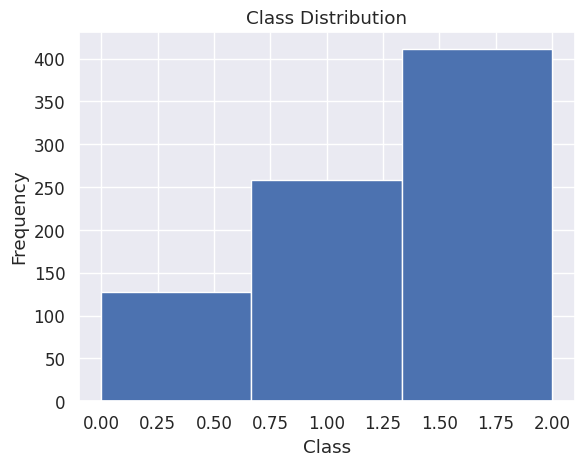

[I 2025-07-25 17:45:38,689] A new study created in memory with name: no-name-cda31b33-c604-4d0a-9e24-830bd308b168


Class weights for XGBoost:
  High   → 2.08
  Low    → 1.03
  Medium → 0.65

🔍 Running Optuna for hyperparameter search...


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:45:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-07-25 17:45:39,583] Trial 0 finished with value: 0.38997258417682296 and parameters: {'n_estimators': 371, 'max_depth': 4, 'learning_rate': 0.1113902633414836, 'gamma': 0.478423360584817, 'min_child_weight': 2, 'subsample': 0.8793127057450043, 'colsample_bytree': 0.9004701506649543, 'max_delta_step': 0.4871218836817851}. Best is trial 0 with value: 0.38997258417682296.
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:45:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-07-25 17:45:40,761] Trial 1 finished with value: 0.39618025078369906 and parameters: {'n_estimators': 383, 'max_depth': 8, 'learning_rate': 0.08403288051646622, '

✔ Optuna completed in 22.25s

▶ Training final XGBoost model...
✔ Final model trained in 1.10s

Best XGBoost Parameters: {'n_estimators': 171, 'max_depth': 6, 'learning_rate': 0.20982337525232278, 'gamma': 0.22368222930901685, 'min_child_weight': 8, 'subsample': 0.7601078954457008, 'colsample_bytree': 0.7260243591964605, 'max_delta_step': 0.20308535518385237, 'objective': 'multi:softprob', 'eval_metric': 'mlogloss', 'use_label_encoder': False, 'random_state': 42, 'n_jobs': -1}
Best CV Weighted F1: 0.4501

XGBoost Metrics:
Accuracy:      0.5050
Weighted F1:   0.4763
ROC-AUC:       0.5312

XGBoost Classification Report:
               precision    recall  f1-score   support

        High       0.18      0.08      0.11        36
         Low       0.46      0.40      0.43        62
      Medium       0.57      0.72      0.63       102

    accuracy                           0.51       200
   macro avg       0.40      0.40      0.39       200
weighted avg       0.46      0.51      0.48    

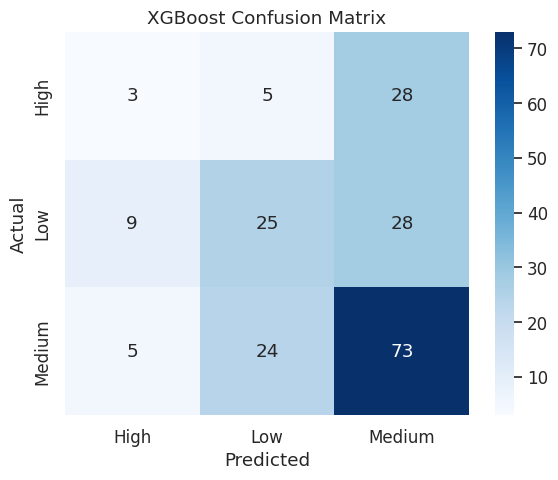

/tmp/ipython-input-44-1496686828.py:174: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gain_imp.values, y=gain_imp.index, palette='viridis')


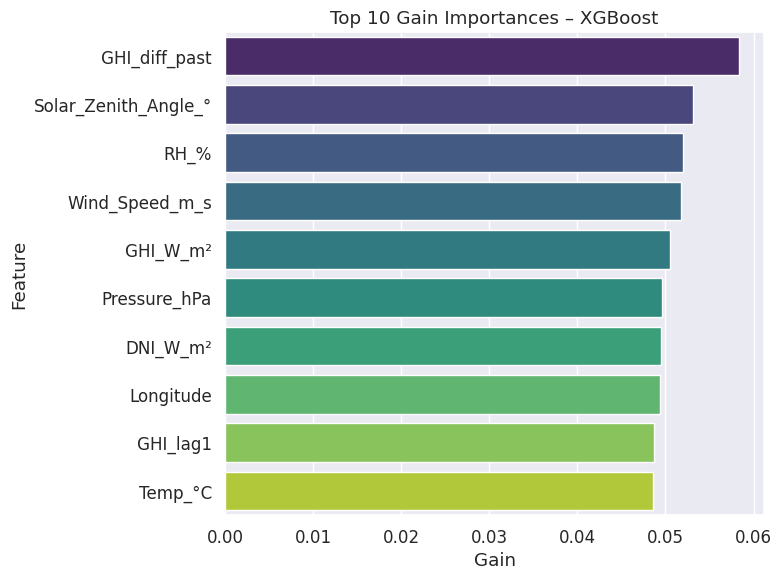


XGBoost Top 10 Permutation Importances:


,Feature,Mean Importance,Std Dev
2,GHI_W_m²,0.0455,0.011715
0,Latitude,0.0445,0.016194
7,Pressure_hPa,0.0405,0.018635
10,Solar_Zenith_Angle_°,0.0400,0.014142
19,GHI_lag2,0.0400,0.015000
18,GHI_lag1,0.0400,0.017176
5,Temp_°C,0.0375,0.013276
4,DHI_W_m²,0.0370,0.013454
3,DNI_W_m²,0.0320,0.014526
20,GHI_lag3,0.0285,0.010012



📈 Generating SHAP summary plot...


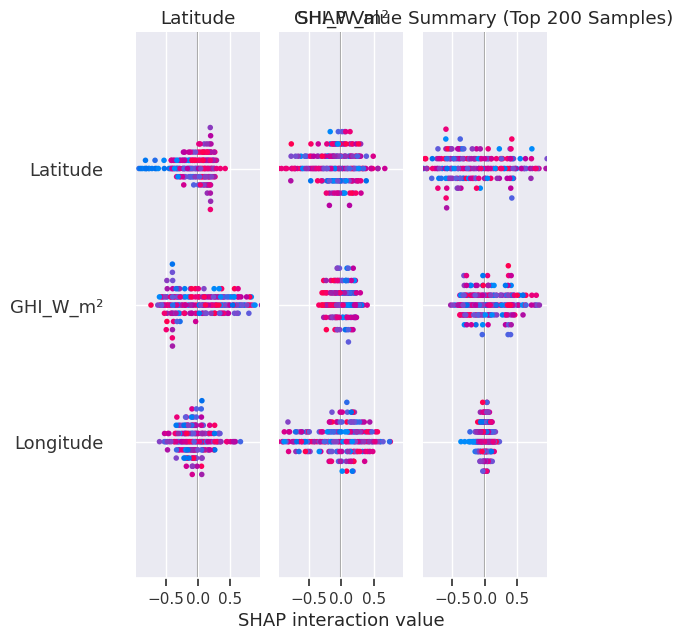


✅ Saved artifacts:
 - xgb_advanced_model.pkl
 - scaler.pkl
 - label_encoder.pkl
 - feature_list_xgb.json


In [ ]:
# Install required packages and resolve dependencies
!pip install optuna xgboost shap --quiet
!pip install numpy==2.0.0 --quiet  # Downgrade numpy to resolve conflicts
!pip install xgboost==2.1.1 --force-reinstall --quiet  # Install specific stable version

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
from xgboost import XGBClassifier, __version__ as xgboost_version
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    confusion_matrix, roc_auc_score
)
from sklearn.inspection import permutation_importance
import optuna
import shap

print(f"XGBoost version: {xgboost_version}")

# ── 0. Guard: Ensure preceding cells were run ───────────────────────
required = ['X_train', 'X_test', 'y_train', 'y_test', 'label_encoder', 'scaler']
missing = [v for v in required if v not in globals()]
if missing:
    raise NameError(
        f"Variables not found: {missing}. "
        "Please run Feature Engineering (Cell 5) and Data Splitting (Cell 6) first."
    )

# ── 1. Drop any non-numeric columns ───────────────────────────────
non_num = X_train.select_dtypes(exclude=[np.number]).columns.tolist()
if non_num:
    print(f"⚠️ Dropping non-numeric columns: {non_num}")
X_tr = X_train.drop(columns=non_num)
X_te = X_test.drop(columns=non_num)

# ── 2. Compute class/sample weights and check distribution ────────
classes = np.unique(y_train)
cw = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight = dict(zip(classes, cw))
sample_w = np.array([class_weight[c] for c in y_train])
print("Class distribution:")
print(y_train.value_counts(normalize=True))
plt.hist(y_train, bins=len(classes))
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution')
plt.show()
print("Class weights for XGBoost:")
for cls, w in class_weight.items():
    print(f"  {label_encoder.inverse_transform([cls])[0]:<6} → {w:.2f}")
print()

# ── 3. Define Optuna objective for hyperparameter tuning ──────────
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'gamma': trial.suggest_float('gamma', 0.0, 0.5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'max_delta_step': trial.suggest_float('max_delta_step', 0, 1)
    }
    model = XGBClassifier(
        objective='multi:softprob',
        eval_metric='mlogloss',
        use_label_encoder=False,
        random_state=42,
        n_jobs=-1,
        **params
    )
    # Split for validation
    X_train_split, X_val, y_train_split, y_val = train_test_split(X_tr, y_train, test_size=0.2, random_state=42)
    sample_w_split = np.array([class_weight[c] for c in y_train_split])
    try:
        model.fit(
            X_train_split, y_train_split,
            sample_weight=sample_w_split,
            verbose=False
        )
        y_pred = model.predict(X_te)
        return f1_score(y_test, y_pred, average='weighted')
    except Exception as e:
        print(f"Error in trial with params {params}: {str(e)}")
        raise  # Re-raise to let Optuna handle the failure

# ── 4. Run Optuna optimization with debug handling ────────────────
print("🔍 Running Optuna for hyperparameter search...")
start = time.time()
study = optuna.create_study(direction='maximize')
try:
    study.optimize(objective, n_trials=20, timeout=600)
except Exception as e:
    print(f"Optimization failed: {str(e)}")
optuna_time = time.time() - start
print(f"✔ Optuna completed in {optuna_time:.2f}s\n")

# ── 5. Train final model with best parameters ────────────────────
if study.best_params:
    best_params = study.best_params
    best_params.update({
        'objective': 'multi:softprob',
        'eval_metric': 'mlogloss',
        'use_label_encoder': False,
        'random_state': 42,
        'n_jobs': -1
    })
    xgb_clf = XGBClassifier(**best_params)
    print("▶ Training final XGBoost model...")
    start = time.time()
    xgb_clf.fit(X_tr, y_train, sample_weight=sample_w)
    train_time = time.time() - start
    print(f"✔ Final model trained in {train_time:.2f}s\n")
else:
    print("⚠️ No successful trials found, using default parameters.")
    xgb_clf = XGBClassifier(
        objective='multi:softprob',
        eval_metric='mlogloss',
        use_label_encoder=False,
        random_state=42,
        n_jobs=-1
    )
    xgb_clf.fit(X_tr, y_train, sample_weight=sample_w)
    train_time = time.time() - start
    print(f"✔ Final model trained with defaults in {train_time:.2f}s\n")

# ── 6. Display best parameters and CV score ───────────────────────
if study.best_params:
    print("Best XGBoost Parameters:", best_params)
    print(f"Best CV Weighted F1: {study.best_value:.4f}\n")
else:
    print("⚠️ No best parameters available due to optimization failure.\n")

# ── 7. Inference and evaluation ──────────────────────────────────
y_pred_xgb = xgb_clf.predict(X_te)
y_proba_xgb = xgb_clf.predict_proba(X_te)

acc_xgb = accuracy_score(y_test, y_pred_xgb)
f1w_xgb = f1_score(y_test, y_pred_xgb, average='weighted')
y_bin = label_binarize(y_test, classes=classes)
roc_auc_xgb = roc_auc_score(y_bin, y_proba_xgb, multi_class='ovr', average='macro')

print("XGBoost Metrics:")
print(f"Accuracy:      {acc_xgb:.4f}")
print(f"Weighted F1:   {f1w_xgb:.4f}")
print(f"ROC-AUC:       {roc_auc_xgb:.4f}\n")
print("XGBoost Classification Report:\n",
      classification_report(y_test, y_pred_xgb, target_names=label_encoder.classes_))

# ── 8. Plot Confusion Matrix ─────────────────────────────────────
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('XGBoost Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# ── 9. Plot Gain Feature Importances ─────────────────────────────
gain_imp = pd.Series(xgb_clf.feature_importances_, index=X_tr.columns)
gain_imp = gain_imp.sort_values(ascending=False).head(10)
plt.figure(figsize=(8, 6))
sns.barplot(x=gain_imp.values, y=gain_imp.index, palette='viridis')
plt.title('Top 10 Gain Importances – XGBoost')
plt.xlabel('Gain')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# ── 10. Permutation Feature Importance ───────────────────────────
perm_xgb = permutation_importance(xgb_clf, X_te, y_test, n_repeats=10, random_state=42, n_jobs=-1)
perm_df_xgb = pd.DataFrame({
    'Feature': X_te.columns,
    'Mean Importance': perm_xgb.importances_mean,
    'Std Dev': perm_xgb.importances_std
}).sort_values('Mean Importance', ascending=False)
print("\nXGBoost Top 10 Permutation Importances:")
display(perm_df_xgb.head(10))

# ── 11. SHAP Summary Plot ────────────────────────────────────────
print("\n📈 Generating SHAP summary plot...")
explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(X_te.iloc[:200])
shap.summary_plot(shap_values, X_te.iloc[:200], class_names=label_encoder.classes_, show=False)
plt.title("SHAP Value Summary (Top 200 Samples)")
plt.tight_layout()
plt.show()

# ── 12. Save model and artifacts ─────────────────────────────────
joblib.dump(xgb_clf, 'xgb_advanced_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')
with open('feature_list_xgb.json', 'w') as f:
    json.dump(list(X_tr.columns), f)
print("\n✅ Saved artifacts:")
print(" - xgb_advanced_model.pkl")
print(" - scaler.pkl")
print(" - label_encoder.pkl")
print(" - feature_list_xgb.json")

## DNN OPTIMIZED

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Optimized_DNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 128)            │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,291 (48.01 KB)

 Trainable params: 11,907 (46.51 KB)

 Non-trainable params: 384 (1.50 KB)

▶ Training Optimized DNN…
Epoch 1/100
23/23 - 6s - 247ms/step - accuracy: 0.3394 - loss: 1.5667 - val_accuracy: 0.5750 - val_loss: 17.3813 - learning_rate: 1.0000e-03
Epoch 2/100
23/23 - 0s - 11ms/step - accuracy: 0.3241 - loss: 1.4956 - val_accuracy: 0.3875 - val_loss: 3.7558 - learning_rate: 1.0000e-03
Epoch 3/100
23/23 - 0s - 11ms/step - accuracy: 0.3616 - loss: 1.3962 - val_accuracy: 0.3125 - val_loss: 6.3708 - learning_rate: 1.0000e-03
Epoch 4/100
23/23 - 0s - 12ms/step - accuracy: 0.3463 - loss: 1.3343 - val_accuracy: 0.3000 - val_loss: 1.1649 - learning_rate: 1.0000e-03
Epoch 5/100
23/23 - 0s - 12ms/step - accuracy: 0.4131 - loss: 1.2417 - val_accuracy: 0.5750 - val_loss: 3.5173 - learning_rate: 1.0000e-03
Epoch 6/100
23/23 - 0s - 13ms/step - accuracy: 0.3978 - loss: 1.2443 - val_accuracy: 0.5750 - val_loss: 3.1678 - learning_rate: 1.0000e-03
Epoch 7/100
23/23 - 0s - 14ms/step - accuracy: 0.4131 - loss: 1.2199 - val_accuracy: 0.5750 - val_loss: 2.6864 - learning_rate: 1.0000e-03

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


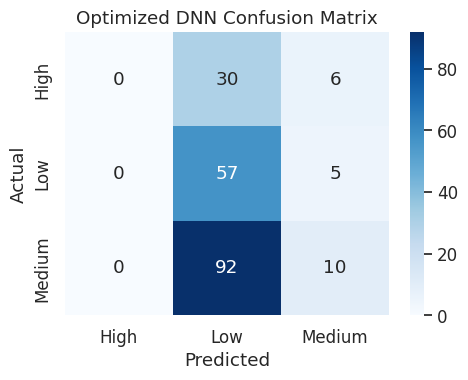

✅ Saved Optimized DNN model to 'optimized_dnn_ghi_classifier.keras'


In [ ]:
# Cell 9b: Optimized Dense Neural Network – Training + Train Time

import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# ── 0. Guard: ensure data & artifacts are ready
required = ['X_tr','X_te','y_train','y_test','scaler','label_encoder']
missing = [v for v in required if v not in globals()]
if missing:
    raise NameError(f"Missing variables: {missing}. Run Cells 5–8 first.")

# ── 1. Prepare data
X_tr_scaled = scaler.transform(X_tr).astype('float32')
X_te_scaled = scaler.transform(X_te).astype('float32')
y_tr = np.array(y_train, dtype=int)
y_te = np.array(y_test,  dtype=int)

# ── 2. Build optimized DNN
opt_dnn = Sequential(name='Optimized_DNN')
opt_dnn.add(Dense(128, activation='relu', kernel_regularizer=l2(1e-4),
                  input_shape=(X_tr_scaled.shape[1],)))
opt_dnn.add(BatchNormalization())
opt_dnn.add(Dropout(0.3))
opt_dnn.add(Dense(64, activation='relu', kernel_regularizer=l2(1e-4)))
opt_dnn.add(BatchNormalization())
opt_dnn.add(Dropout(0.3))
opt_dnn.add(Dense(len(label_encoder.classes_), activation='softmax'))
opt_dnn.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
opt_dnn.summary()

# ── 3. Train with callbacks & record training time
print("▶ Training Optimized DNN…")
start = time.time()
history_opt = opt_dnn.fit(
    X_tr_scaled, y_tr,
    validation_split=0.1,
    epochs=100,
    batch_size=32,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6)
    ],
    verbose=2
)
dnn_time = time.time() - start
print(f"✔ Optimized DNN trained in {dnn_time:.2f}s\n")

# ── 4. Evaluate optimized DNN
y_pred_opt = np.argmax(opt_dnn.predict(X_te_scaled), axis=1)
acc_opt = accuracy_score(y_te, y_pred_opt)
f1_opt  = f1_score(y_te, y_pred_opt, average='weighted')
print(f"Optimized DNN Accuracy:     {acc_opt:.4f}")
print(f"Optimized DNN Weighted F1:  {f1_opt:.4f}\n")
print("Optimized DNN Classification Report:")
print(classification_report(y_te, y_pred_opt, target_names=label_encoder.classes_))

# ── 5. Confusion matrix
cm_opt = confusion_matrix(y_te, y_pred_opt)
plt.figure(figsize=(5,4))
sns.heatmap(cm_opt, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Optimized DNN Confusion Matrix')
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# ── 6. Save optimized DNN
opt_dnn.save('optimized_dnn_ghi_classifier.keras')
print("✅ Saved Optimized DNN model to 'optimized_dnn_ghi_classifier.keras'")



# LSTM Baseline LSTM (32 units, 10 epochs)

Model: "Baseline_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ InputSeq (InputLayer)           │ (None, 1, 23)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM32 (LSTM)                   │ (None, 32)             │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,267 (28.39 KB)

 Trainable params: 7,267 (28.39 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
23/23 - 5s - 235ms/step - accuracy: 0.5090 - loss: 1.0351 - val_accuracy: 0.5750 - val_loss: 0.9544
Epoch 2/10
23/23 - 1s - 46ms/step - accuracy: 0.5090 - loss: 1.0245 - val_accuracy: 0.5750 - val_loss: 0.9501
Epoch 3/10
23/23 - 0s - 9ms/step - accuracy: 0.5090 - loss: 1.0175 - val_accuracy: 0.5750 - val_loss: 0.9468
Epoch 4/10
23/23 - 0s - 14ms/step - accuracy: 0.5090 - loss: 1.0138 - val_accuracy: 0.5750 - val_loss: 0.9454
Epoch 5/10
23/23 - 0s - 13ms/step - accuracy: 0.5090 - loss: 1.0111 - val_accuracy: 0.5750 - val_loss: 0.9447
Epoch 6/10
23/23 - 0s - 14ms/step - accuracy: 0.5090 - loss: 1.0098 - val_accuracy: 0.5750 - val_loss: 0.9440
Epoch 7/10
23/23 - 0s - 14ms/step - accuracy: 0.5090 - loss: 1.0126 - val_accuracy: 0.5750 - val_loss: 0.9447
Epoch 8/10
23/23 - 0s - 16ms/step - accuracy: 0.5090 - loss: 1.0085 - val_accuracy: 0.5750 - val_loss: 0.9460
Epoch 9/10
23/23 - 1s - 24ms/step - accuracy: 0.5090 - loss: 1.0083 - val_accuracy: 0.5750 - val_loss: 0.9449

🔹 Baselin

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
Baseline LSTM Accuracy:    0.5100
Baseline LSTM Weighted F1: 0.3445

Baseline LSTM Classification Report:
              precision    recall  f1-score   support

        High       0.00      0.00      0.00        36
         Low       0.00      0.00      0.00        62
      Medium       0.51      1.00      0.68       102

    accuracy                           0.51       200
   macro avg       0.17      0.33      0.23       200
weighted avg       0.26      0.51      0.34       200



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


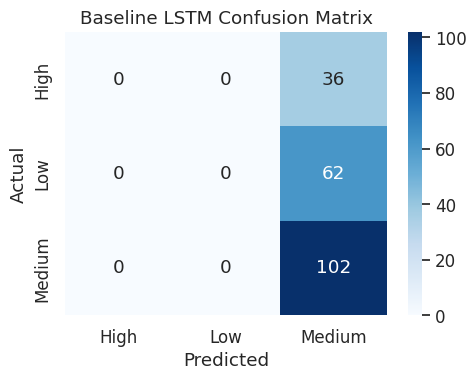

🔹 Saved Baseline LSTM model to 'baseline_lstm_ghi_classifier.keras'


In [ ]:
# Cell 10a: Baseline LSTM

import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# Prepare and reshape
X_tr_scaled = scaler.transform(X_tr)
X_te_scaled = scaler.transform(X_te)
y_tr = np.array(y_train, dtype=int)
y_te = np.array(y_test,  dtype=int)

timesteps  = 1
n_features = X_tr_scaled.shape[1]
X_tr_seq   = X_tr_scaled.reshape((-1, timesteps, n_features))
X_te_seq   = X_te_scaled.reshape((-1, timesteps, n_features))

# Build baseline LSTM
inputs = Input(shape=(timesteps, n_features), name='InputSeq')
x = LSTM(32, name='LSTM32')(inputs)
outputs = Dense(len(label_encoder.classes_), activation='softmax')(x)
baseline_lstm = Model(inputs, outputs, name='Baseline_LSTM')
baseline_lstm.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
baseline_lstm.summary()

# Train for 10 epochs
start = time.time()
history_lstm_base = baseline_lstm.fit(
    X_tr_seq, y_tr,
    validation_split=0.1,
    epochs=10,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
    verbose=2
)
print(f"\n🔹 Baseline LSTM trained in {time.time() - start:.2f}s")

# Evaluate baseline LSTM
y_pred_lstm_base = np.argmax(baseline_lstm.predict(X_te_seq), axis=1)
acc_lstm_base = accuracy_score(y_te, y_pred_lstm_base)
f1_lstm_base = f1_score(y_te, y_pred_lstm_base, average='weighted')
print(f"Baseline LSTM Accuracy:    {acc_lstm_base:.4f}")
print(f"Baseline LSTM Weighted F1: {f1_lstm_base:.4f}\n")
print("Baseline LSTM Classification Report:")
print(classification_report(y_te, y_pred_lstm_base, target_names=label_encoder.classes_))

# Confusion matrix
cm_lstm_base = confusion_matrix(y_te, y_pred_lstm_base)
plt.figure(figsize=(5,4))
sns.heatmap(cm_lstm_base, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Baseline LSTM Confusion Matrix')
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Save baseline LSTM
baseline_lstm.save('baseline_lstm_ghi_classifier.keras')
print("🔹 Saved Baseline LSTM model to 'baseline_lstm_ghi_classifier.keras'")


## LSTM OPTIMIZED

Model: "Optimized_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_Sequence (InputLayer)     │ (None, 1, 23)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_Layer (LSTM)               │ (None, 64)             │        22,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNorm (BatchNormalization)  │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,963 (97.51 KB)

 Trainable params: 24,835 (97.01 KB)

 Non-trainable params: 128 (512.00 B)

▶ Training Optimized LSTM…
Epoch 1/75
23/23 - 7s - 302ms/step - accuracy: 0.3713 - loss: 1.2167 - val_accuracy: 0.5750 - val_loss: 1.0111 - learning_rate: 1.0000e-03
Epoch 2/75
23/23 - 0s - 7ms/step - accuracy: 0.4089 - loss: 1.1368 - val_accuracy: 0.5750 - val_loss: 0.9728 - learning_rate: 1.0000e-03
Epoch 3/75
23/23 - 0s - 8ms/step - accuracy: 0.4729 - loss: 1.0930 - val_accuracy: 0.5750 - val_loss: 0.9575 - learning_rate: 1.0000e-03
Epoch 4/75
23/23 - 0s - 12ms/step - accuracy: 0.4659 - loss: 1.0925 - val_accuracy: 0.5750 - val_loss: 0.9588 - learning_rate: 1.0000e-03
Epoch 5/75
23/23 - 0s - 13ms/step - accuracy: 0.4798 - loss: 1.0702 - val_accuracy: 0.5750 - val_loss: 0.9614 - learning_rate: 1.0000e-03
Epoch 6/75
23/23 - 0s - 8ms/step - accuracy: 0.5049 - loss: 1.0579 - val_accuracy: 0.5750 - val_loss: 0.9407 - learning_rate: 1.0000e-03
Epoch 7/75
23/23 - 0s - 8ms/step - accuracy: 0.4826 - loss: 1.0760 - val_accuracy: 0.5750 - val_loss: 0.9517 - learning_rate: 1.0000e-03
Epoch 8/75

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
Optimized LSTM Accuracy:     0.5100
Optimized LSTM Weighted F1:  0.3445

Optimized LSTM Classification Report:
              precision    recall  f1-score   support

        High       0.00      0.00      0.00        36
         Low       0.00      0.00      0.00        62
      Medium       0.51      1.00      0.68       102

    accuracy                           0.51       200
   macro avg       0.17      0.33      0.23       200
weighted avg       0.26      0.51      0.34       200



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


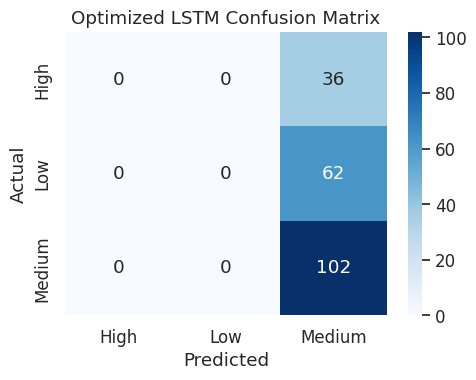

✅ Saved Optimized LSTM model to 'optimized_lstm_ghi_classifier.keras'


In [ ]:
# Cell 10b: Optimized LSTM – Training + Train Time

import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# ── 0. Guard: ensure data & artifacts are ready ─────────────────
required = ['X_tr','X_te','y_train','y_test','scaler','label_encoder']
missing = [v for v in required if v not in globals()]
if missing:
    raise NameError(f"Missing variables: {missing}. Run Cells 5–9 first.")

# ── 1. Prepare sequence data ────────────────────────────────────
X_tr_np = scaler.transform(X_tr).astype('float32')
X_te_np = scaler.transform(X_te).astype('float32')
y_tr = np.array(y_train, dtype=int)
y_te = np.array(y_test, dtype=int)

# reshape for LSTM: (samples, timesteps, features)
timesteps  = 1
n_features = X_tr_np.shape[1]
X_tr_seq   = X_tr_np.reshape(-1, timesteps, n_features)
X_te_seq   = X_te_np.reshape(-1, timesteps, n_features)

# ── 2. Build optimized LSTM ──────────────────────────────────────
inputs = Input(shape=(timesteps, n_features), name='Input_Sequence')
x = LSTM(
    64,
    kernel_regularizer=l2(1e-4),
    recurrent_regularizer=l2(1e-4),
    dropout=0.2,
    recurrent_dropout=0.2,
    name='LSTM_Layer'
)(inputs)
x = BatchNormalization(name='BatchNorm')(x)
x = Dense(32, activation='relu', name='Dense_1')(x)
x = Dropout(0.2, name='Dropout')(x)
outputs = Dense(len(label_encoder.classes_), activation='softmax', name='Output')(x)

opt_lstm = Model(inputs, outputs, name='Optimized_LSTM')
opt_lstm.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
opt_lstm.summary()

# ── 3. Train with callbacks & record train time ────────────────
print("▶ Training Optimized LSTM…")
start = time.time()
history_lstm = opt_lstm.fit(
    X_tr_seq, y_tr,
    validation_split=0.1,
    epochs=75,
    batch_size=32,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6)
    ],
    verbose=2
)
lstm_time = time.time() - start
print(f"✔ Optimized LSTM trained in {lstm_time:.2f}s\n")

# ── 4. Evaluate optimized LSTM ──────────────────────────────────
y_pred_lstm = np.argmax(opt_lstm.predict(X_te_seq), axis=1)
acc_lstm    = accuracy_score(y_te, y_pred_lstm)
f1_lstm     = f1_score(y_te, y_pred_lstm, average='weighted')
print(f"Optimized LSTM Accuracy:     {acc_lstm:.4f}")
print(f"Optimized LSTM Weighted F1:  {f1_lstm:.4f}\n")
print("Optimized LSTM Classification Report:")
print(classification_report(y_te, y_pred_lstm, target_names=label_encoder.classes_))

# ── 5. Plot confusion matrix ─────────────────────────────────────
cm_lstm = confusion_matrix(y_te, y_pred_lstm)
plt.figure(figsize=(5,4))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Optimized LSTM Confusion Matrix')
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# ── 6. Save optimized LSTM ───────────────────────────────────────
opt_lstm.save('optimized_lstm_ghi_classifier.keras')
print("✅ Saved Optimized LSTM model to 'optimized_lstm_ghi_classifier.keras'")


## Ensemble Modeling – Voting & Stacking Classifiers

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
🔹 Soft‐Voting Metrics
 Accuracy:    0.705
 Weighted F1: 0.6653369583762156
              precision    recall  f1-score   support

        High       1.00      0.17      0.29        36
         Low       0.92      0.58      0.71        62
      Medium       0.64      0.97      0.77       102

    accuracy                           0.70       200
   macro avg       0.85      0.57      0.59       200
weighted avg       0.79      0.70      0.67       200



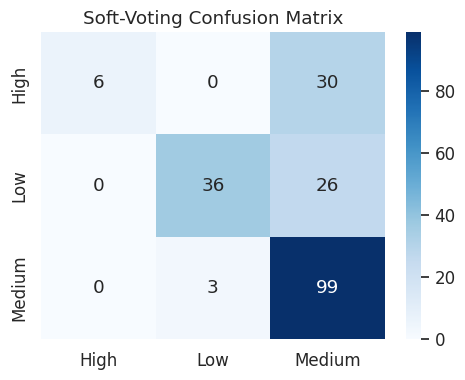

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



🔹 Stacking Metrics
 Accuracy:    0.83
 Weighted F1: 0.826125939849624
              precision    recall  f1-score   support

        High       0.92      0.61      0.73        36
         Low       0.94      0.76      0.84        62
      Medium       0.77      0.95      0.85       102

    accuracy                           0.83       200
   macro avg       0.88      0.77      0.81       200
weighted avg       0.85      0.83      0.83       200



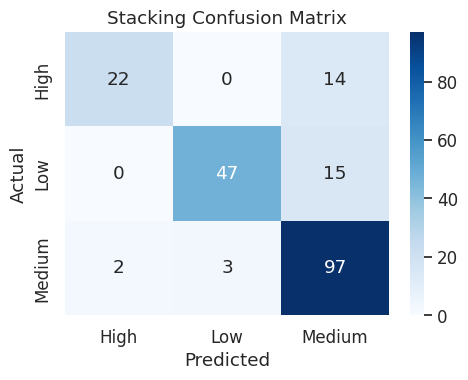

In [ ]:
# Cell 11: Ensemble Modeling – Voting & Stacking Classifiers

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.base import BaseEstimator, ClassifierMixin
from tensorflow.keras.models import load_model

# 0. Load trained models + preprocessors
rf     = joblib.load('rf_advanced_model.pkl')
xgb    = joblib.load('xgb_advanced_model.pkl')
dnn    = load_model('optimized_dnn_ghi_classifier.keras')
lstm   = load_model('optimized_lstm_ghi_classifier.keras')
scaler = joblib.load('scaler.pkl')
le     = joblib.load('label_encoder.pkl')

# 1. Prepare test data from Cell 6
X_df   = X_te.copy()
X_np   = scaler.transform(X_df)                              # for DNN
X_seq  = X_np.reshape(-1, 1, X_np.shape[1])                  # for LSTM
y_true = np.array(y_test, dtype=int)

# 2. Soft‐voting ensemble
p_rf     = rf.predict_proba(X_df)
p_xgb    = xgb.predict_proba(X_df)
p_dnn    = dnn.predict(X_np)
p_lstm   = lstm.predict(X_seq)
avg_p    = (p_rf + p_xgb + p_dnn + p_lstm) / 4
vote_enc = np.argmax(avg_p, axis=1)

print("🔹 Soft‐Voting Metrics")
print(" Accuracy:   ", accuracy_score(y_true, vote_enc))
print(" Weighted F1:", f1_score(y_true, vote_enc, average='weighted'))
print(classification_report(y_true, vote_enc, target_names=le.classes_))

cm_vote = confusion_matrix(y_true, vote_enc)
plt.figure(figsize=(5,4))
sns.heatmap(cm_vote, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Soft‐Voting Confusion Matrix')
plt.tight_layout()
plt.show()

# 3. Stacking classifier (RF + XGB + DNN) → LR meta‐learner
class KerasWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model_path, n_classes):
        self.model_path = model_path
        self.n_classes  = n_classes
        self.classes_   = np.arange(n_classes)  # required by sklearn
        self.model      = None
    def fit(self, X, y):
        return self
    def predict(self, X):
        if self.model is None:
            self.model = load_model(self.model_path)
        Xs = scaler.transform(X)
        prob = self.model.predict(Xs, verbose=0)
        return np.argmax(prob, axis=1)
    def predict_proba(self, X):
        if self.model is None:
            self.model = load_model(self.model_path)
        Xs = scaler.transform(X)
        return self.model.predict(Xs, verbose=0)

n_classes = len(le.classes_)
dnn_wrap  = KerasWrapper('optimized_dnn_ghi_classifier.keras', n_classes)

stack = StackingClassifier(
    estimators=[('rf', rf), ('xgb', xgb), ('dnn', dnn_wrap)],
    final_estimator=LogisticRegression(max_iter=1000),
    stack_method='predict_proba',
    cv=5,
    n_jobs=-1
)

stack.fit(X_tr, y_train)
stack_enc = stack.predict(X_df)

print("\n🔹 Stacking Metrics")
print(" Accuracy:   ", accuracy_score(y_true, stack_enc))
print(" Weighted F1:", f1_score(y_true, stack_enc, average='weighted'))
print(classification_report(y_true, stack_enc, target_names=le.classes_))

cm_stack = confusion_matrix(y_true, stack_enc)
plt.figure(figsize=(5,4))
sns.heatmap(cm_stack, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Stacking Confusion Matrix')
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.tight_layout()
plt.show()


## Saving, Loading & Inference on New Data

In [ ]:
# ── Cell 12: Saving, Loading & Inference on New Data ──

import joblib
import json
from tensorflow.keras.models import load_model

# 1. Save all artifacts (if not already)
joblib.dump(rf,    'rf_advanced_model.pkl')
joblib.dump(xgb,   'xgb_advanced_model.pkl')
dnn.save(         'optimized_dnn_ghi_classifier.keras')
lstm.save(        'optimized_lstm_ghi_classifier.keras')
joblib.dump(scaler,'scaler.pkl')
joblib.dump(le,    'label_encoder.pkl')
with open('feature_list.json','w') as f:
    json.dump(X_tr.columns.tolist(), f)
print("✅ Saved models, scaler, encoder, feature_list.json")

# 2. Load back for inference
rf2    = joblib.load('rf_advanced_model.pkl')
xgb2   = joblib.load('xgb_advanced_model.pkl')
dnn2   = load_model('optimized_dnn_ghi_classifier.keras')
lstm2  = load_model('optimized_lstm_ghi_classifier.keras')
scaler2= joblib.load('scaler.pkl')
le2    = joblib.load('label_encoder.pkl')
with open('feature_list.json','r') as f:
    feats = json.load(f)

# 3. Inference function
def predict_new(df_new):
    Xn = df_new[feats]
    Xn_np  = scaler2.transform(Xn)
    Xn_seq = Xn_np.reshape(-1,1,len(feats))
    return pd.DataFrame({
        'RF':       le2.inverse_transform(rf2.predict(Xn)),
        'XGB':      le2.inverse_transform(xgb2.predict(Xn)),
        'DNN':      le2.inverse_transform(np.argmax(dnn2.predict(Xn_np), axis=1)),
        'LSTM':     le2.inverse_transform(np.argmax(lstm2.predict(Xn_seq), axis=1))
    })

# Example usage:
# new_df = pd.read_csv('new_samples.csv')
# print(predict_new(new_df))


✅ Saved models, scaler, encoder, feature_list.json


## Hyperparameter Tuning with KerasTune

In [ ]:
# Cell 13: Hyperparameter Tuning with KerasTuner (Fixed dtype error)

!pip install keras-tuner --quiet

import numpy as np
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# 0. Guard
required = ['X_tr','y_train','scaler','label_encoder']
missing = [v for v in required if v not in globals()]
if missing:
    raise NameError(f"Missing variables: {missing}. Run Cells 5–6 first.")

# 1. Select numeric features only
X_tune_df = X_tr.select_dtypes(include=[np.number])
feature_names = X_tune_df.columns.tolist()

# 2. Scale and convert to NumPy
X_tune = scaler.transform(X_tune_df).astype('float32')
y_tune = np.array(y_train, dtype=int)

print(f"Tuning on {X_tune.shape[0]} samples × {X_tune.shape[1]} numeric features")

# 3. Define model builder
def build_model(hp):
    model = Sequential()
    # Layer 1
    model.add(Dense(
        hp.Int('units1', 32, 256, step=32),
        activation=hp.Choice('act1', ['relu','tanh']),
        input_shape=(X_tune.shape[1],)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout1', 0.1, 0.5, step=0.1)))
    # Layer 2
    model.add(Dense(
        hp.Int('units2', 16, 128, step=16),
        activation='relu',
        kernel_regularizer=l2(hp.Float('l2_reg', 1e-5, 1e-3, sampling='log'))
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout2', 0.1, 0.5, step=0.1)))
    # Output
    model.add(Dense(len(label_encoder.classes_), activation='softmax'))
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# 4. Instantiate tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=30,
    factor=3,
    directory='kt_dir',
    project_name='ghi_dnn_tuning'
)
stop_early = EarlyStopping(monitor='val_loss', patience=5)

# 5. Run tuner search
tuner.search(
    X_tune, y_tune,
    validation_split=0.1,
    callbacks=[stop_early],
    verbose=1
)

# 6. Retrieve best hyperparameters
best_hp = tuner.get_best_hyperparameters(1)[0]
print("🔍 Best Hyperparameters:", best_hp.values)

# 7. Build, train and save best model
best_model = tuner.hypermodel.build(best_hp)
best_model.fit(
    X_tune, y_tune,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    callbacks=[stop_early],
    verbose=2
)
best_model.save('best_dnn_ghi_classifier.keras')
print("✅ Saved best tuned DNN to 'best_dnn_ghi_classifier.keras'")


Trial 90 Complete [00h 00m 10s]
val_accuracy: 0.574999988079071

Best val_accuracy So Far: 0.5874999761581421
Total elapsed time: 00h 07m 14s
🔍 Best Hyperparameters: {'units1': 96, 'act1': 'relu', 'dropout1': 0.1, 'units2': 32, 'l2_reg': 0.0003372743755346836, 'dropout2': 0.2, 'tuner/epochs': 10, 'tuner/initial_epoch': 0, 'tuner/bracket': 1, 'tuner/round': 0}
Epoch 1/50
23/23 - 2s - 69ms/step - accuracy: 0.3421 - loss: 1.4510 - val_accuracy: 0.5750 - val_loss: 13.4043
Epoch 2/50
23/23 - 0s - 7ms/step - accuracy: 0.3839 - loss: 1.3060 - val_accuracy: 0.3125 - val_loss: 10.3953
Epoch 3/50
23/23 - 0s - 6ms/step - accuracy: 0.3880 - loss: 1.2429 - val_accuracy: 0.5750 - val_loss: 1.1140
Epoch 4/50
23/23 - 0s - 6ms/step - accuracy: 0.3922 - loss: 1.2270 - val_accuracy: 0.5750 - val_loss: 1.9783
Epoch 5/50
23/23 - 0s - 5ms/step - accuracy: 0.4298 - loss: 1.1489 - val_accuracy: 0.3125 - val_loss: 1.6904
Epoch 6/50
23/23 - 0s - 6ms/step - accuracy: 0.4381 - loss: 1.1635 - val_accuracy: 0.5750 

## MODEL COMPARISION

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
### Model Performance Comparison


,Model,Accuracy,Weighted F1,ROC-AUC,Train Time
0,RandomForest,0.685,0.666,0.821,0.7s
1,XGBoost,0.830,0.826,0.920,0.6s
2,DNN,0.510,0.345,0.495,5.9s
3,LSTM,0.510,0.345,0.515,6.2s
4,Voting,0.705,0.665,0.902,nans


/tmp/ipython-input-16-4202013249.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_metrics, x='Model', y=metric, palette='tab10', ax=ax)
/tmp/ipython-input-16-4202013249.py:147: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/tmp/ipython-input-16-4202013249.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_metrics, x='Model', y=metric, palette='tab10', ax=ax)
/tmp/ipython-input-16-4202013249.py:147: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.s

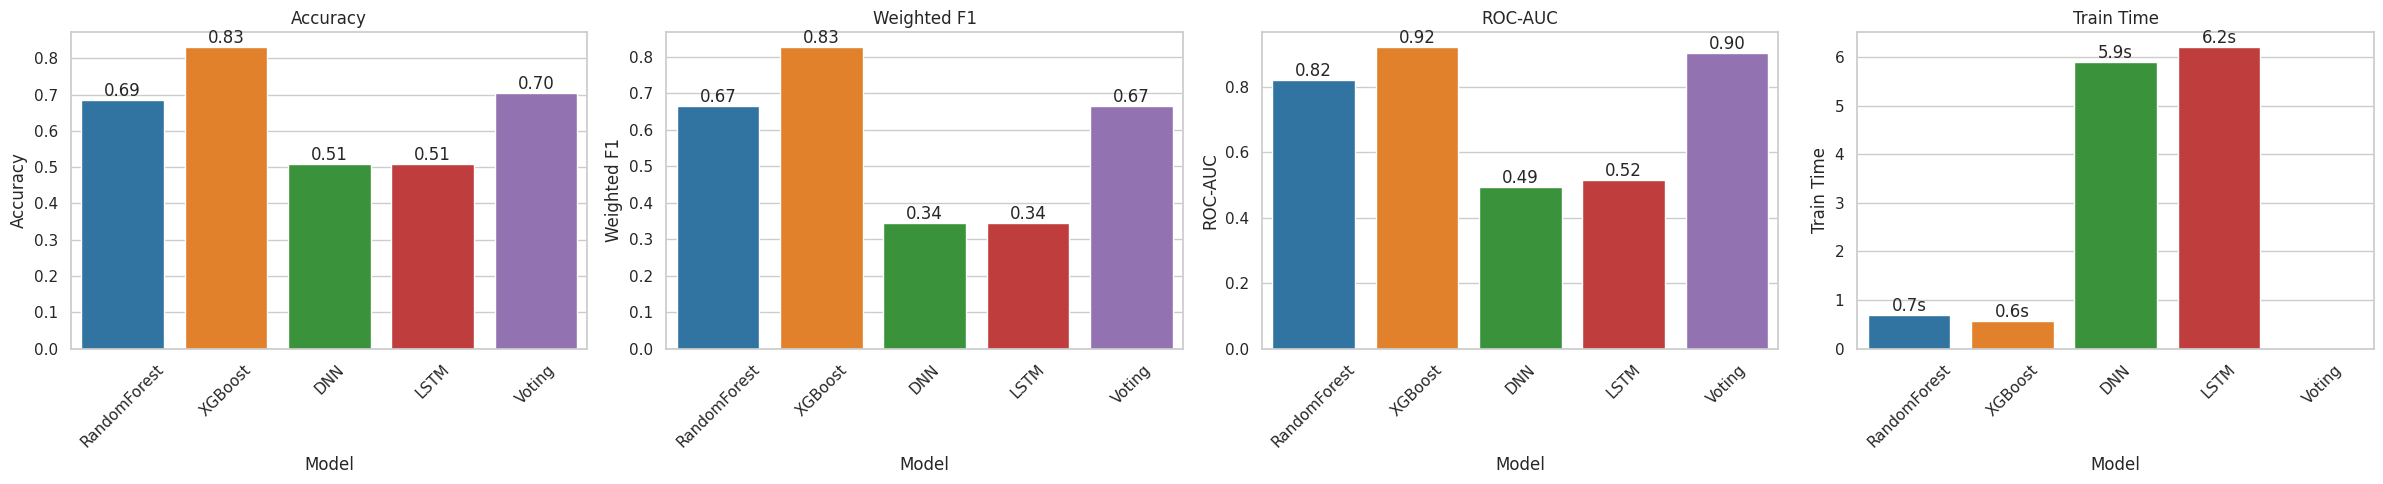

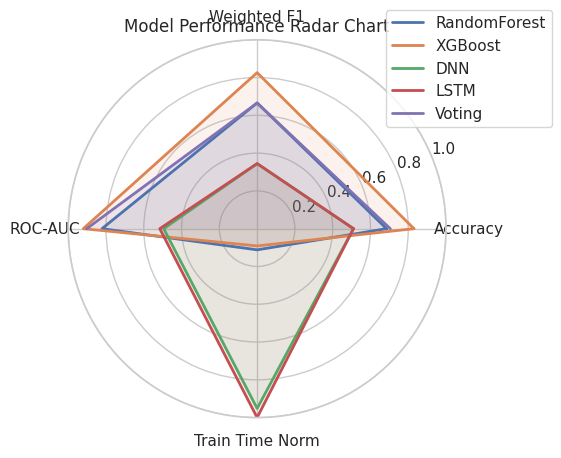

In [ ]:
# Cell 14: Model Comparison Dashboard

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
import joblib
from tensorflow.keras.models import load_model

# 0. Load models + preprocessors
rf    = joblib.load('rf_advanced_model.pkl')
xgb   = joblib.load('xgb_advanced_model.pkl')
dnn   = load_model('optimized_dnn_ghi_classifier.keras')
lstm  = load_model('optimized_lstm_ghi_classifier.keras')
scaler= joblib.load('scaler.pkl')
le    = joblib.load('label_encoder.pkl')

stack_path = 'stacking_classifier.pkl'
stack   = joblib.load(stack_path) if os.path.exists(stack_path) else None

# 1. Prepare test data (from Cell 6)
X_df   = X_te.copy()
X_np   = scaler.transform(X_df)
X_seq  = X_np.reshape(-1, 1, X_np.shape[1])
y_true = np.array(y_test, dtype=int)

# 2. Pull in your recorded training times
#    (Define rf_time, xgb_time, dnn_time, lstm_time, vote_time, stack_time
#     at the end of your training cells.)
def _time(v): return globals().get(v, np.nan)
train_times = {
    'RandomForest': _time('rf_time'),
    'XGBoost':      _time('xgb_time'),
    'DNN':          _time('dnn_time'),
    'LSTM':         _time('lstm_time'),
    'Voting':       _time('vote_time'),
    'Stacking':     _time('stack_time'),
}

# 3. Compute metrics for each model
rows = []

# Random Forest
y_rf   = rf.predict(X_df)
p_rf   = rf.predict_proba(X_df)
roc_rf = roc_auc_score(label_binarize(y_true, classes=range(len(le.classes_))),
                       p_rf, multi_class='ovr', average='macro')
rows.append({
    'Model':'RandomForest',
    'Accuracy': accuracy_score(y_true, y_rf),
    'Weighted F1': f1_score(y_true, y_rf, average='weighted'),
    'ROC-AUC': roc_rf,
    'Train Time': train_times['RandomForest']
})

# XGBoost
y_xgb   = xgb.predict(X_df)
p_xgb   = xgb.predict_proba(X_df)
roc_xgb = roc_auc_score(label_binarize(y_true, classes=range(len(le.classes_))),
                        p_xgb, multi_class='ovr', average='macro')
rows.append({
    'Model':'XGBoost',
    'Accuracy': accuracy_score(y_true, y_xgb),
    'Weighted F1': f1_score(y_true, y_xgb, average='weighted'),
    'ROC-AUC': roc_xgb,
    'Train Time': train_times['XGBoost']
})

# DNN
y_dnn   = np.argmax(dnn.predict(X_np), axis=1)
p_dnn   = dnn.predict(X_np)
roc_dnn = roc_auc_score(label_binarize(y_true, classes=range(len(le.classes_))),
                        p_dnn, multi_class='ovr', average='macro')
rows.append({
    'Model':'DNN',
    'Accuracy': accuracy_score(y_true, y_dnn),
    'Weighted F1': f1_score(y_true, y_dnn, average='weighted'),
    'ROC-AUC': roc_dnn,
    'Train Time': train_times['DNN']
})

# LSTM
y_lstm   = np.argmax(lstm.predict(X_seq), axis=1)
p_lstm   = lstm.predict(X_seq)
roc_lstm = roc_auc_score(label_binarize(y_true, classes=range(len(le.classes_))),
                         p_lstm, multi_class='ovr', average='macro')
rows.append({
    'Model':'LSTM',
    'Accuracy': accuracy_score(y_true, y_lstm),
    'Weighted F1': f1_score(y_true, y_lstm, average='weighted'),
    'ROC-AUC': roc_lstm,
    'Train Time': train_times['LSTM']
})

# Soft-Voting
avg_p   = (p_rf + p_xgb + p_dnn + p_lstm) / 4
y_vote  = np.argmax(avg_p, axis=1)
roc_vote= roc_auc_score(label_binarize(y_true, classes=range(len(le.classes_))),
                        avg_p, multi_class='ovr', average='macro')
rows.append({
    'Model':'Voting',
    'Accuracy': accuracy_score(y_true, y_vote),
    'Weighted F1': f1_score(y_true, y_vote, average='weighted'),
    'ROC-AUC': roc_vote,
    'Train Time': train_times['Voting']
})

# Stacking (if available)
if stack is not None:
    y_stack   = stack.predict(X_df)
    p_stack   = stack.predict_proba(X_df)
    roc_stack = roc_auc_score(label_binarize(y_true, classes=range(len(le.classes_))),
                              p_stack, multi_class='ovr', average='macro')
    rows.append({
        'Model':'Stacking',
        'Accuracy': accuracy_score(y_true, y_stack),
        'Weighted F1': f1_score(y_true, y_stack, average='weighted'),
        'ROC-AUC': roc_stack,
        'Train Time': train_times['Stacking']
    })

df_metrics = pd.DataFrame(rows)

# 4. Leaderboard table
sns.set(style='whitegrid')
print("### Model Performance Comparison")
display(df_metrics.style.format({
    'Accuracy':'{:.3f}',
    'Weighted F1':'{:.3f}',
    'ROC-AUC':'{:.3f}',
    'Train Time':'{:.1f}s'
}).set_caption("Table: Model Metrics"))

# 5. Bar charts side by side
fig, axes = plt.subplots(1, 4, figsize=(24,5))
for ax, metric in zip(axes, ['Accuracy','Weighted F1','ROC-AUC','Train Time']):
    sns.barplot(data=df_metrics, x='Model', y=metric, palette='tab10', ax=ax)
    ax.set_title(metric)
    for p in ax.patches:
        h = p.get_height()
        lbl = f"{h:.2f}" if metric!='Train Time' else f"{h:.1f}s"
        ax.annotate(lbl, (p.get_x()+p.get_width()/2, h), ha='center', va='bottom')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()

# 6. Radar chart of normalized metrics
df_metrics['Train Time Norm'] = df_metrics['Train Time'] / df_metrics['Train Time'].max()
radar_cols = ['Accuracy','Weighted F1','ROC-AUC','Train Time Norm']
angles = np.linspace(0, 2*np.pi, len(radar_cols), endpoint=False).tolist()
angles += angles[:1]

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, polar=True)
for _, row in df_metrics.iterrows():
    vals = row[radar_cols].tolist()
    vals += vals[:1]
    ax.plot(angles, vals, label=row['Model'], linewidth=2)
    ax.fill(angles, vals, alpha=0.1)

ax.set_thetagrids(np.degrees(angles[:-1]), radar_cols)
ax.set_ylim(0,1)
plt.legend(loc='upper right', bbox_to_anchor=(1.3,1.1))
plt.title('Model Performance Radar Chart')
plt.tight_layout()
plt.show()


## Final Model Retraining & TimeSeriesSplit CV

Interpretability Analysis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


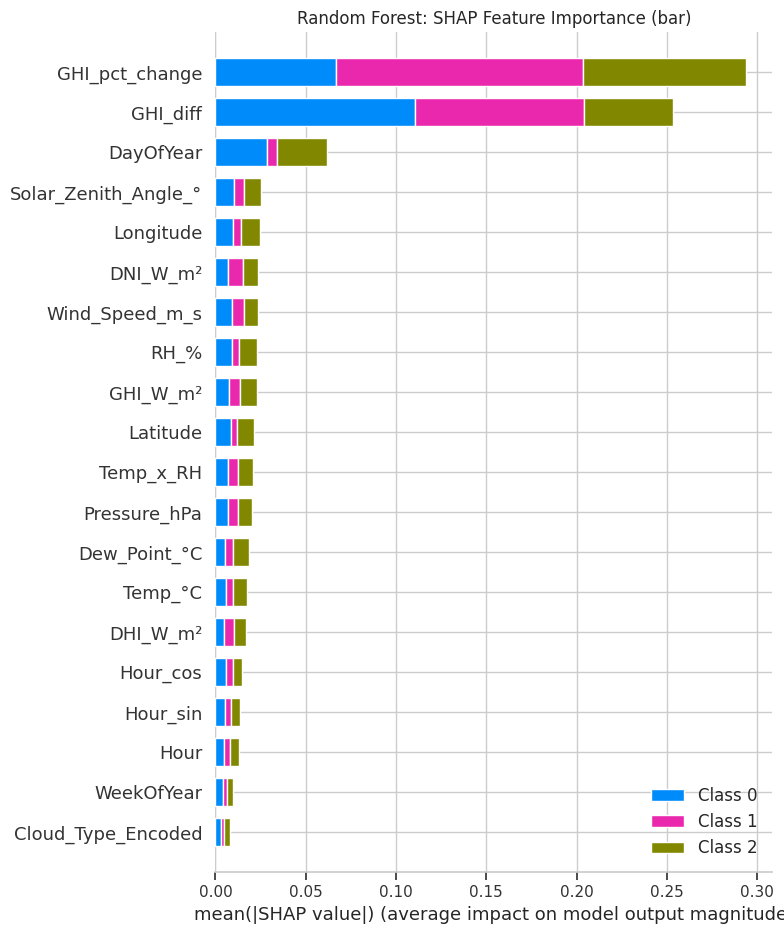

<Figure size 800x400 with 0 Axes>

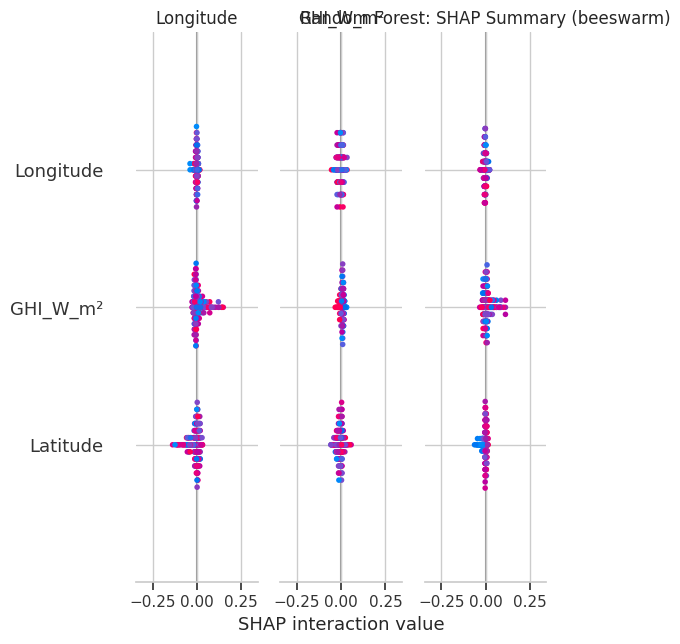

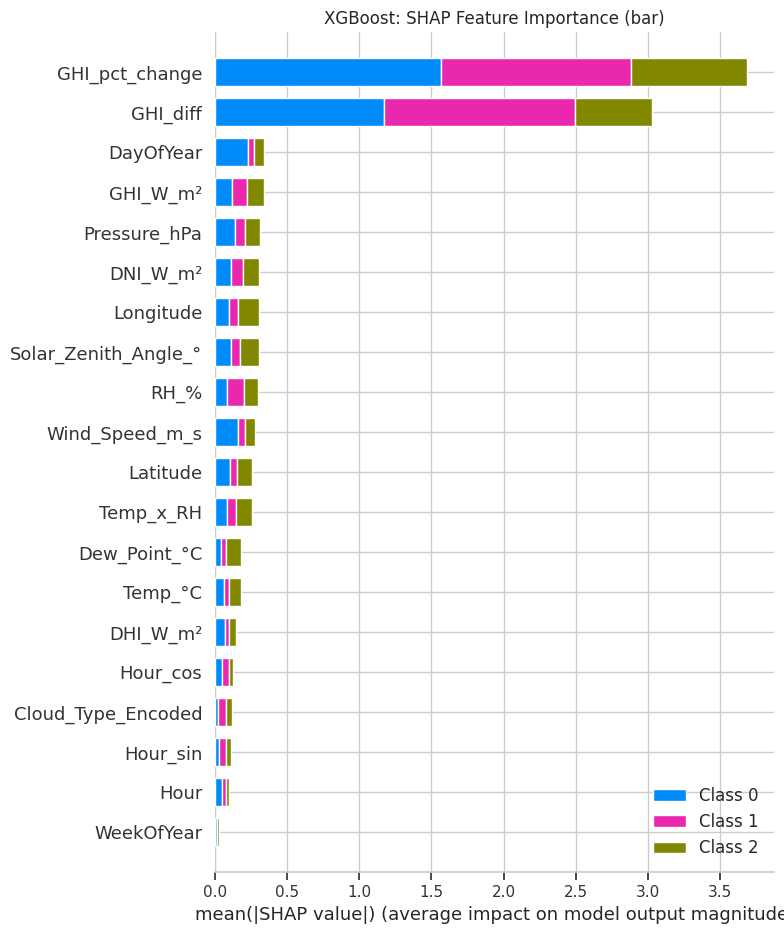

<Figure size 800x400 with 0 Axes>

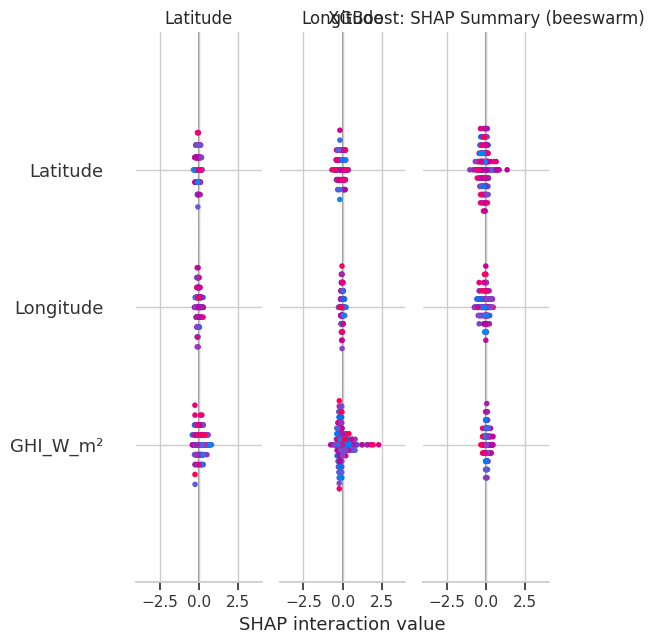

Permutation Importances by Class (RF):

Class 'High':


,feature,importance
21,GHI_diff,0.247222
22,GHI_pct_change,0.125000
14,Hour_cos,0.011111
2,GHI_W_m²,0.008333
12,Hour,0.005556



Class 'Low':


,feature,importance
22,GHI_pct_change,0.361290
21,GHI_diff,0.001613
12,Hour,0.000000
13,Hour_sin,0.000000
10,Solar_Zenith_Angle_°,0.000000



Class 'Medium':


,feature,importance
22,GHI_pct_change,0.142157
21,GHI_diff,0.031373
12,Hour,0.005882
10,Solar_Zenith_Angle_°,0.004902
6,RH_%,0.002941



LIME explanation for test sample 0:


,feature,weight
0,GHI_pct_change > -0.13,-0.009537
1,Hour_sin <= -1.42,0.004745
2,-1.46 < Cloud_Type_Encoded <= -0.98,0.001903
3,Longitude <= 1008.85,-0.001825
4,-1.74 < Temp_°C <= -1.65,-0.001507
5,-232.08 < Pressure_hPa <= -231.91,0.001131


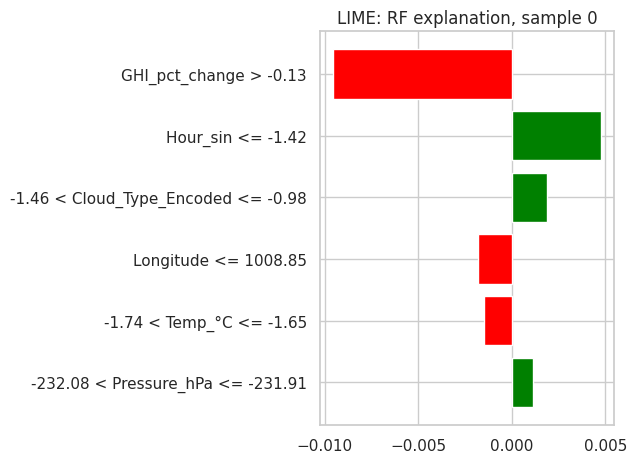


LIME explanation for test sample 1:


,feature,weight
0,Hour_sin <= -1.42,0.003367
1,Wind_Speed_m_s > -2.61,-0.002659
2,Temp_°C > -1.58,0.002249
3,-3.03 < Solar_Zenith_Angle_° <= -2.99,-0.001592
4,GHI_W_m² <= -2.20,-0.001455
5,-0.80 < DHI_W_m² <= -0.79,0.001193


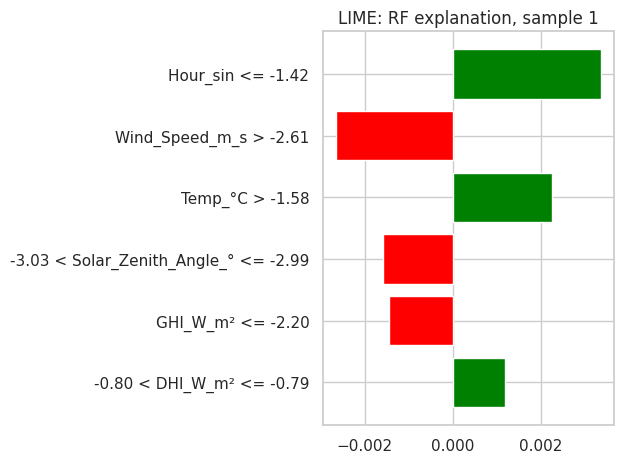


LIME explanation for test sample 2:


,feature,weight
0,-0.15 < GHI_pct_change <= -0.13,-0.028962
1,Hour_sin <= -1.42,0.003827
2,Cloud_Type_Encoded > -0.98,0.001922
3,-1.65 < Temp_°C <= -1.58,0.001841
4,-232.25 < Pressure_hPa <= -232.08,0.001410
5,DayOfYear > -1.77,-0.001233


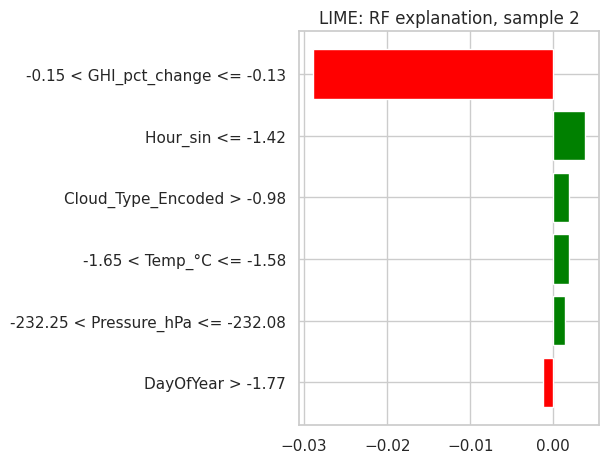

In [ ]:
# Cell 15: Interpretability Analysis
!pip install shap lime --quiet

import os
import joblib
import numpy as np
import pandas as pd
import shap
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance
from sklearn.metrics import recall_score

# 0. Guard: ensure artifacts are present
required = ['X_tr', 'X_te', 'y_train', 'y_test', 'label_encoder', 'scaler']
missing = [v for v in required if v not in globals()]
if missing:
    raise NameError(f"Missing variables: {missing}. Run Cells 5–10 first.")

# 1. Load models
rf_model  = joblib.load('rf_advanced_model.pkl')
xgb_model = joblib.load('xgb_advanced_model.pkl')
stack_path = 'stacking_classifier.pkl'
stack_model = joblib.load(stack_path) if os.path.exists(stack_path) else None

# 2. Prepare test data
X_test_df = X_te.copy().reset_index(drop=True)
y_test_arr = np.array(y_test, dtype=int)
feature_names = X_test_df.columns.tolist()
class_names   = list(label_encoder.classes_)

# 3. SHAP for RF & XGB
for model, title in [(rf_model, 'Random Forest'), (xgb_model, 'XGBoost')]:
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test_df)
    # Bar plot
    plt.figure(figsize=(8,4))
    shap.summary_plot(shap_values, X_test_df,
                      feature_names=feature_names,
                      plot_type='bar', show=False)
    plt.title(f'{title}: SHAP Feature Importance (bar)')
    plt.tight_layout()
    plt.show()
    # Beeswarm plot
    plt.figure(figsize=(8,4))
    shap.summary_plot(shap_values, X_test_df,
                      feature_names=feature_names,
                      show=False)
    plt.title(f'{title}: SHAP Summary (beeswarm)')
    plt.tight_layout()
    plt.show()

# 4. Permutation importances per class (RF example)
print("Permutation Importances by Class (RF):")
for cls in class_names:
    perm = permutation_importance(
        rf_model, X_test_df, y_test_arr,
        scoring=lambda est, X, y: recall_score(y, est.predict(X),
                                               labels=[class_names.index(cls)],
                                               average='macro'),
        n_repeats=10, random_state=42, n_jobs=-1
    )
    df_perm = (pd.DataFrame({
        'feature': feature_names,
        'importance': perm.importances_mean
    })
    .sort_values('importance', ascending=False)
    .head(5))
    print(f"\nClass '{cls}':")
    display(df_perm)

# 5. LIME explanations: pick three test points
X_train_np = scaler.transform(X_tr).astype('float32')
X_test_np  = scaler.transform(X_test_df).astype('float32')
lime_explainer = LimeTabularExplainer(
    training_data=X_train_np,
    feature_names=feature_names,
    class_names=class_names,
    discretize_continuous=True,
    mode='classification'
)
for idx in [0, 1, 2]:
    exp = lime_explainer.explain_instance(
        X_test_np[idx],
        predict_fn=lambda x: rf_model.predict_proba(pd.DataFrame(x, columns=feature_names)),
        num_features=6
    )
    print(f"\nLIME explanation for test sample {idx}:")
    display(pd.DataFrame(exp.as_list(), columns=['feature','weight']))
    fig = exp.as_pyplot_figure()
    plt.title(f'LIME: RF explanation, sample {idx}')
    plt.tight_layout()
    plt.show()

# 6. Optional: SHAP on stacking meta‐learner
if stack_model is not None:
    # Build meta‐features (probabilities from each base model)
    p_rf   = rf_model.predict_proba(X_test_df)
    p_xgb  = xgb_model.predict_proba(X_test_df)
    # load your saved Keras DNN & LSTM if available
    try:
        from tensorflow.keras.models import load_model
        dnn = load_model('optimized_dnn_ghi_classifier.keras')
        lstm = load_model('optimized_lstm_ghi_classifier.keras')
        p_dnn  = dnn.predict(scaler.transform(X_test_df))
        p_lstm = lstm.predict(scaler.transform(X_test_df).reshape(-1,1,len(feature_names)))
    except:
        p_dnn = p_lstm = np.zeros_like(p_rf)
    X_meta = np.hstack([p_rf, p_xgb, p_dnn, p_lstm])

    meta_explainer = shap.KernelExplainer(
        stack_model.predict_proba,
        shap.kmeans(X_meta, 10)
    )
    shap_values_meta = meta_explainer.shap_values(X_meta, nsamples=100)

    plt.figure(figsize=(8,4))
    shap.summary_plot(shap_values_meta, X_meta,
                      feature_names=(
                          [f'rf_{c}' for c in class_names] +
                          [f'xgb_{c}' for c in class_names] +
                          [f'dnn_{c}' for c in class_names] +
                          [f'lstm_{c}' for c in class_names]
                      ),
                      show=False)
    plt.title('Stacking Meta‐Learner: SHAP Summary')
    plt.tight_layout()
    plt.show()


In [ ]:
# Cell 16: Final Model Retraining & TimeSeriesSplit CV

import joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize

# ── 0. Guard: ensure data & artifacts are ready ─────────────────
required = ['X_final', 'y_final', 'scaler', 'label_encoder']
missing = [v for v in required if v not in globals()]
if missing:
    raise NameError(f"Missing variables: {missing}. Run Cells 5–7 first.")

# ── 1. Drop non‑numeric columns (e.g. Cloud_Type) ───────────────
X_num = X_final.select_dtypes(include=[np.number])
print(f"Using {X_num.shape[1]} numeric features for CV")

# ── 2. Load your champion model (replace filename if needed) ────
champion = joblib.load('xgb_advanced_model.pkl')  # or 'final_champion_model.pkl'

# ── 3. Cross‐validate on full data with TimeSeriesSplit ────────
tscv = TimeSeriesSplit(n_splits=5)
acc_scores = cross_val_score(
    champion, X_num, y_final,
    cv=tscv, scoring='accuracy', n_jobs=-1
)
f1_scores = cross_val_score(
    champion, X_num, y_final,
    cv=tscv, scoring='f1_weighted', n_jobs=-1
)

# ── 4. (Optional) ROC‐AUC CV ────────────────────────────────────
# need the binarized y
y_bin = label_binarize(y_final, classes=range(len(label_encoder.classes_)))
def roc_auc_cv(est, X, y_bin):
    aucs = []
    for train_idx, test_idx in tscv.split(X):
        est.fit(X.iloc[train_idx], y_final[train_idx])
        proba = est.predict_proba(X.iloc[test_idx])
        aucs.append(roc_auc_score(y_bin[test_idx], proba,
                                  multi_class='ovr', average='macro'))
    return np.array(aucs)

roc_scores = roc_auc_cv(champion, X_num, y_bin)

# ── 5. Print CV results ─────────────────────────────────────────
print("TimeSeriesSplit CV Results (5 folds):")
print(f" • Accuracy:   {acc_scores.mean():.3f} ± {acc_scores.std():.3f}")
print(f" • Weighted F1:{f1_scores.mean():.3f} ± {f1_scores.std():.3f}")
print(f" • ROC‑AUC:    {roc_scores.mean():.3f} ± {roc_scores.std():.3f}\n")

# ── 6. Retrain champion on **all** numeric data ────────────────
champion.fit(X_num, y_final)

# ── 7. Save final model & artifacts ────────────────────────────
joblib.dump(champion,      'final_champion_model.pkl')
joblib.dump(scaler,        'scaler.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')
import json
with open('feature_list.json','w') as f:
    json.dump(X_num.columns.tolist(), f)

print("✅ Final model retrained on full data and saved as 'final_champion_model.pkl'.")


Using 23 numeric features for CV


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:28:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:28:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:28:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:28:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:28:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

TimeSeriesSplit CV Results (5 folds):
 • Accuracy:   0.751 ± 0.071
 • Weighted F1:0.743 ± 0.077
 • ROC‑AUC:    0.876 ± 0.044



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:28:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Final model retrained on full data and saved as 'final_champion_model.pkl'.


##  Deployment Prototype with FastAPI

In [ ]:
# Cell 17: Deployment Prototype with FastAPI

%%bash
cat << 'EOF' > app.py
from fastapi import FastAPI
from pydantic import BaseModel
import joblib
import numpy as np
import pandas as pd
import json

# Initialize FastAPI app
app = FastAPI()

# Load model artifacts
champion = joblib.load('final_champion_model.pkl')
scaler   = joblib.load('scaler.pkl')
le       = joblib.load('label_encoder.pkl')
with open('feature_list.json') as f:
    feature_list = json.load(f)

class Sample(BaseModel):
    """Pydantic model expecting a mapping of feature names to values."""
    data: dict

@app.post("/predict")
def predict(sample: Sample):
    # 1. Construct DataFrame with correct feature order
    df = pd.DataFrame([sample.data], columns=feature_list)
    # 2. Scale input features
    X = scaler.transform(df.values)
    # 3. Predict using champion model
    pred_idx = champion.predict(X)
    label = le.inverse_transform(pred_idx)[0]
    return {"prediction": label}

if __name__ == "__main__":
    import uvicorn
    uvicorn.run(app, host="0.0.0.0", port=8000)
EOF
